### Notebook overview and goals

This notebook builds a clause-centric, graph-ready representation of legal contracts using LLMs. It is organized into modular phases you can run independently:

- Phase 1 (global async) — Extract edges per clause with high-throughput LLM calls
  - Edges include: `IS_PART_OF`, `DEFINES`, `USES`, `CONTAINS`, `REFERENCES`, `MENTION_PARTY`.
  - Uses global concurrency across all contracts/clauses to fully utilize your paid rate limits.
- Phase 1.5 — Consolidate and deduplicate edges
  - Produces both a complete graph of nodes, and edges.
- Metrics & QA — Compute dataset-level metrics, visualize distributions, and identify outliers
  - Helps validate extraction quality and spot anomalies before downstream use.

Outputs are written under Google Drive paths (configurable)

In [ ]:
# ======================================================================
# Step 1: Setup and Imports
# ======================================================================
# === SFT pair builder for Grok with flattened nodes, full instructions, and rich debug ===
!pip -q install --upgrade openai backoff tqdm aiofiles

import os, re, json, asyncio, traceback
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import aiofiles
import backoff
from tqdm.auto import tqdm
from openai import AsyncOpenAI
from google.colab import drive, userdata
import json
import os
from pathlib import Path
from tqdm.notebook import tqdm

print("Mounting Google Drive...")
drive.mount('/content/drive', force_remount=True)
print("Drive mounted successfully.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 810.8/810.8 kB 44.4 MB/s eta 0:00:00
Mounting Google Drive...
Mounted at /content/drive
Drive mounted successfully.


In [ ]:
# ------------------------ CONFIG ------------------------
# Folders
PROMPT_VERSION = "v4"
DRIVE_ROOT = Path("/content/drive/MyDrive")
PARSED_CONTRACTS_DIR = DRIVE_ROOT / "charboundry_parsed_contractsv3_debug"
OUT_BASE  = DRIVE_ROOT / "sft_minigraph_openai_full_alt_test"
PAIRS_DIR = OUT_BASE / PROMPT_VERSION / "pairs"
ERROR_DIR = OUT_BASE / PROMPT_VERSION / "_errors"
DEBUG_DIR = OUT_BASE / PROMPT_VERSION / "_debug"
for d in (PAIRS_DIR, ERROR_DIR, DEBUG_DIR):
    d.mkdir(parents=True, exist_ok=True)

PARSED_GLOB = "*_sentence_parser_fixed.json"

MAX_CONCURRENCY = 3

XAI_API_KEY = userdata.get('grok')
OPENAI_API_KEY = userdata.get('OpenAIService')
TEMPERATURE = 0.0
MAX_COMPLETION_TOKENS = 4096

# Truncation for printing (to keep logs readable in Colab output)
PRINT_JSON_PREVIEW_CHARS = 2000000  # preview size for printed request/response

assert XAI_API_KEY, "Missing Colab secret 'grok' (xAI API key). Set it: Colab → Extensions → Secrets."
#MODEL_ID = "grok-4-0709"
#client = AsyncOpenAI(base_url="https://api.x.ai/v1", api_key=XAI_API_KEY)
MODEL_ID = "gpt-5-chat-latest"
client = AsyncOpenAI(api_key=OPENAI_API_KEY)


In [ ]:
import re
from pathlib import Path

def safe_name(s: str, maxlen: int = 120) -> str:
    s = re.sub(r'[^A-Za-z0-9._-]+', '_', str(s))
    s = re.sub(r'_{2,}', '_', s).strip('._-')
    return s[:maxlen] or "untitled"


In [ ]:
# ------------------------ V1 LEAN PROMPT TEXT (YOUR FULL BLOCK) ------------------------
SYSTEM_PROMPT = """You are a deterministic contract‑clause graph extractor. You read exactly one clause and emit a minimal, correct mini‑graph as JSON.
Return valid JSON only (no markdown, no explanations). Think step‑by‑step internally; do not expose your reasoning."""

PROMPT_INSTRUCTION = """
You are a legal-graph extractor. Your task is to analyze the given `clause` text and extract all relevant nodes and edges that are explicitly mentioned or defined within it.

**INPUT:**
- `contract_id`: The ID of the contract.
- `clause`: An object with the `id`, `title`, and `text` of the clause to analyze.

**OUTPUT RULES:**
1.  Return a single, valid JSON object with two keys: "nodes" and "edges". Do not include any other text, explanations, or markdown.
2.  **Node Creation:** Create nodes ONLY for entities mentioned in the clause text.
    - `CLAUSE`: Create a node for the input `clause` itself.
    - `DEFINED_TERM`: Create nodes for terms defined with phrases like `("Term")`, `shall mean`, etc. Canonicalize the name (e.g., "this Agreement" becomes "Agreement").
    - `PARTY`: Create nodes for named parties (e.g., "Miltenyi Biotec GmbH") or roles (e.g., "the Parties").
    - `VALUE`: Create nodes for specific values like dates ("March 27, 2019").
3.  **Edge Creation:** Create edges to represent relationships originating FROM the input `clause`.
    - `DEFINES`: From the clause to a `DEFINED_TERM` it defines.
    - `MENTION_PARTY`: From the clause to a `PARTY` it mentions.
    - `CONTAINS`: From the clause to a `VALUE` it contains.
4.  Ignore headers, redaction notices, and other non-contractual text.

**EXAMPLE:**
- **Input:** `{"contract_id": "C-123", "clause": {"id": "1.1", "text": "This Agreement ('Agreement') is made on Jan 1, 2023 by Acme Inc."}}`
- **Expected JSON Output:**
  ```json
  {
    "nodes": [
      { "id": "1.1", "node_type": "CLAUSE", "title": null },
      { "id": "term:Agreement", "node_type": "DEFINED_TERM", "name": "Agreement" },
      { "id": "value:Jan 1, 2023", "node_type": "VALUE", "unit": "Date", "text": "Jan 1, 2023" },
      { "id": "party:Acme Inc.", "node_type": "PARTY", "name": "Acme Inc." }
    ],
    "edges": [
      { "src": "1.1", "tgt": "term:Agreement", "type": "DEFINES" },
      { "src": "1.1", "tgt": "value:Jan 1, 2023", "type": "CONTAINS" },
      { "src": "1.1", "tgt": "party:Acme Inc.", "type": "MENTION_PARTY" }
    ]
  }"""

In [ ]:
# ------------------------ V2 LEAN PROMPT TEXT (YOUR FULL BLOCK) ------------------------

SYSTEM_PROMPT = """
You are a deterministic legal‑graph extractor. Return ONE valid JSON object only (no prose/markdown). Do all reasoning internally and do NOT print it."""
PROMPT_INSTRUCTION = """
TASK:
From THIS clause alone, create only the nodes/edges that the text supports.

NODES (create only when supported)
- CLAUSE:        {"id":"<clause-id>","node_type":"CLAUSE","title":"<title>"}
- DEFINED_TERM:  {"id":"term:<Canonical>","node_type":"DEFINED_TERM","name":"<Canonical>"}
- PARTY:         {"id":"party:<surface>","node_type":"PARTY","name":"<surface>"}
- VALUE:         {"id":"value:<literal>","node_type":"VALUE","unit":"Currency|Percentage|Days|BusinessDays|Months|Years|Date|Count","text":"<literal>"}

EDGES (emit once per unique (src,tgt,type); ALL edges originate from the input clause id)
- DEFINES (clause → DEFINED_TERM) when `"X" means`, `X shall mean`, or `"X" (the "X")` (canonicalize “this Agreement”→“Agreement”).
- USES (clause → DEFINED_TERM) when a defined term is used (case/quote‑insensitive).
- MENTION_PARTY (clause → PARTY) for proper names/roles (Licensor, Licensee, the Parties, the Customer), whole‑word, case‑insensitive.
- CONTAINS (clause → VALUE) for dates, currency, percentages, durations, counts.

HYGIENE
- Deduplicate nodes by id and edges by (src,tgt,type); sort nodes by id and edges by src,type,tgt.
- Ignore redactions [***], TOC dots, pagination leaders.
- Prefer a small certain set over guesses.

INPUT
contract_id: {{contract_id}}
clause: {"id":"{{clause.id}}","title":"{{clause.title}}","text":"{{clause.text}}"}

OUTPUT (strict JSON)
{"contract_id":"{{contract_id}}","nodes":[...],"edges":[...]}
"""

In [ ]:
# ------------------------V3 PROMPT TEXT FULL------------------------
SYSTEM_PROMPT = """You are a deterministic contract‑clause graph extractor. You read exactly one clause and emit a minimal, correct mini‑graph as JSON.
Return valid JSON only (no markdown, no explanations). Think step‑by‑step internally; do not expose your reasoning."""

PROMPT_INSTRUCTION = """
Task: From this clause alone, create nodes and edges the text actually supports.

Input variables
contract_id = {contract_id}
clause = {clause}

Node types (create only when supported by the text/rules)
1. CLAUSE
{{"id":"<clause-id>", "node_type":"CLAUSE", "title":"<title>"}}
2.DEFINED_TERM
{{"id":"term:<canonical>", "node_type":"DEFINED_TERM", "name":"<canonical>"}}
3. PARTY
{{"id":"party:<surface>", "node_type":"PARTY", "name":"<surface>"}}
4.VALUE
{{"id":"value:<literal>", "node_type":"VALUE", "unit":"Currency|Percentage|Days|BusinessDays|Months|Years|Date|Count", "text":"<literal>"}}

Edge types (emit once per unique (src, tgt, type) triple)
1. IS_PART_OF (CLAUSE → parent CLAUSE)
2. REFERENCES (CLAUSE → CLAUSE)
3. DEFINES (CLAUSE → DEFINED_TERM)
4. USES (CLAUSE → DEFINED_TERM)
5. MENTION_PARTY (CLAUSE → PARTY)
6. CONTAINS (CLAUSE → VALUE)

Rules (apply in order; then dedup/sort)
1.Create the child CLAUSE node for clause.
2. Parent inference / IS_PART_OF:
3. Infer parent id from id/title:
"1.2.3" → "1.2"; "3.4" → "3"; "14.2" → "ARTICLE 14" (or "14" if doc uses numeric style); "ARTICLE 1" → "ROOT".
4. Create the parent CLAUSE node if not present (title = id if unknown; level = child.level - 1).
5. Add IS_PART_OF(child→parent).
6. REFERENCES: If the text names another clause (e.g., “Section 5.4”, “Article 10”, “§14.3”, “Exhibit B”, “Schedule 1”), create that CLAUSE node (title = id if unknown) and add REFERENCES(child→referenced).
7. DEFINED_TERM — DEFINES:
If text defines a term: "X" means …, X shall mean …, or "X" (the "X"), create term:<X> (canonicalize this Agreement → Agreement; strip quotes; title‑case common terms) and add DEFINES(child→term).
8.DEFINED_TERM — USES:
If text uses a defined term (case/quote‑insensitive; this Agreement ≈ Agreement), create/use term:<canonical> and add USES(child→term).
Tie‑break: if variants match, use the canonical base (e.g., Capital Initials).
9. PARTY — MENTION_PARTY:
Create/use PARTY nodes for proper names and role words with article/capitalization (e.g., “Licensor”, “Licensee”, “the Parties”, “the Customer”) matched as whole words (case‑insensitive). Add MENTION_PARTY(child→party).
10. VALUE — CONTAINS:
Create VALUE nodes from obvious spans; set unit and literal text.
• Currency, Percentage, and text+numeric like “two percent (2%)”, Days/BusinessDays/Months/Years: numeric or text‑numeric + unit (e.g., “thirty (30) days”, “6 months”)
• Date/Count: recognizable dates (“March 27, 2019”), counts (“one (1)”)
Add CONTAINS(child→value).

Clean‑up:
Deduplicate nodes by id and edges by (src,tgt,type).
Sort deterministically (nodes by id asc; edges by src,type,tgt).
Ignore redactions [*****], TOC dots, pagination leaders, and formatting artifacts.
Prefer a small correct set over speculative links.
Output contract (strict JSON only)

{
  "contract_id": "{{contract_id}}",
  "clause_id: "{clause.id}",
  "nodes": [ ... ],
  "edges": [ ... ]
}


Tiny example (for pattern anchoring; do not reference outside the given clause during inference)
Input (abbrev.):
contract_id: "C-001"
clause: {{ id: "1.2.3", title: "Definitions", level: 3, text: "\"Service\" means the hosted platform provided by Licensor." }}

Expected (abbrev.):

{
  "contract_id": "C-001",
  "clause_id": "1.2.3",
  "nodes": [
    {{"id":"1.2.3","node_type":"CLAUSE","title":"Definitions","level":3}},
    {{"id":"1.2","node_type":"CLAUSE","title":"1.2","level":2}},
    {{"id":"term:Service","node_type":"DEFINED_TERM","name":"Service"}},
    {{"id":"party:Licensor","node_type":"PARTY","name":"Licensor"}}
  ],
  "edges": [
    {{"src":"1.2.3","tgt":"1.2","type":"IS_PART_OF"}},
    {{"src":"1.2.3","tgt":"term:Service","type":"DEFINES"}},
    {{"src":"1.2.3","tgt":"party:Licensor","type":"MENTION_PARTY"}}
  ]
}
Here is the input clause:
"""


In [ ]:
# ------------------------V4 PROMPT TEXT FULL------------------------
SYSTEM_PROMPT = """You will receive the full details of ONE clause: {id, text, title, level}."""

PROMPT_INSTRUCTION = """
Your task is to act as a legal graph extractor. From this single clause, create a self-contained set of nodes and edges that are explicitly supported by the text. Follow the reasoning process, rules, and clarifications below.

Output ONLY a single, strict JSON object with this structure:

{
 "contract_id": "...",
 "nodes": [ ... ],
 "edges": [ ... ]
}

──────────────────────────
REASONING PROCESS
──────────────────────────
1.  **Isolate Core Text:** First, mentally separate the core contractual prose from any 'noise' like Tables of Contents, redaction headers, or formatting artifacts. Your analysis should ONLY focus on the contractual prose.
2.  **Create Primary Node:** Create the `CLAUSE` node for the clause you were given.
3.  **Infer and Create Parent Node:** Analyze the clause `id` to infer the parent clause ID. Create the parent `CLAUSE` node and the IS_PART_OF edge to it.
4.  **Scan and Create Nodes:** Read the core text to identify all other entities (Referenced Clauses, Defined Terms, Parties, Values) and create their corresponding nodes according to the rules below.
5.  **Create Edges:** Link the primary clause node to all other created nodes using the appropriate edge types.

──────────────────────────
NODE RULES
──────────────────────────
- CLAUSE:
  { "id": "<clause-id>", "node_type": "CLAUSE", "title": "<title>", "level": <int> }
  Rule: Create a node for the input clause, its inferred parent, and any clauses it explicitly references.

- DEFINED_TERM:
  { "id": "term:<Canonical Term>", "node_type": "DEFINED_TERM", "name": "<Canonical Term>" }
  Rule: Create for terms with special meaning (quoted, ALL CAPS, or explicitly defined). Canonicalize the name (e.g., "this Agreement" becomes "Agreement"; use Title Case).

- PARTY:
  { "id": "party:<Party Name>", "node_type": "PARTY", "name": "<Party Name>" }
  Rule: Only for legal entities or defined roles (e.g., "Licensor", "the Supplier"). Canonicalize by removing articles ("the", "a").

- VALUE:
  { "id": "value:<literal text>", "node_type": "VALUE", "unit": "Currency|Percentage|Days|Months|Years", "text": "<literal text>" }
  Rule: Extract specific amounts, durations, etc.

──────────────────────────
EDGE RULES
──────────────────────────
Format: { "src":"<id>", "tgt":"<id>", "type":"<EDGE_TYPE>" }

- IS_PART_OF: CLAUSE → parent CLAUSE
  Rule: Infer parent from child's ID. Numeric: "3.4" → "3"; "14.2" → "ARTICLE 14". Non-numeric: For an ID like "(h)", look for context in the text like "Section 3.2(h)" to infer the parent is "3.2".

- DEFINES: CLAUSE → DEFINED_TERM
  Rule: Use when the clause introduces a definition (“X shall mean...”, “(the ‘X’)”).

- USES: CLAUSE → DEFINED_TERM
  Rule: Use when a defined term is mentioned but not defined in this clause. Be thorough and include all capitalized, multi-word legal concepts (e.g., "Material Change", "Product Prices").

- REFERENCES: CLAUSE → CLAUSE
  Rule: Use for explicit cross-references like “Section 3.2” or “Article 10”.

- MENTIONS_PARTY: CLAUSE → PARTY
  Rule: Create an edge for every mentioned party.

- CONTAINS: CLAUSE → VALUE
  Rule: Create an edge for every extracted value.

──────────────────────────
CRITICAL CLARIFICATIONS
──────────────────────────
1.  **Reference Typing is Key:** Any cross-reference to another part of the document (e.g., "Article 5", "Exhibit B") MUST be created as a `CLAUSE` node. It is NEVER a `DEFINED_TERM`.
2.  **No Duplicates:** Output each unique node and edge only once. If no nodes or edges can be created, output empty arrays.
3.  **Sort for Consistency:** Sort nodes by ID and edges by `src`, `type`, then `tgt`."""

In [ ]:

# Structured output schema to enforce the shape of the result
Minigraph_JSON_SCHEMA = {
    "name": "Minigraph",
    "schema": {
        "title": "ClauseGraphResponse.Lean",
        "type": "object",
        "additionalProperties": False,
        "required": ["contract_id", "nodes", "edges"],
        "properties": {
          "contract_id": { "type": "string" },
          "nodes": {
            "type": "array",
            "items": {
              "type": "object",
              "additionalProperties": False,
              "required": ["id", "node_type"],
              "properties": {
                "id": { "type": "string" },
                "node_type": {
                  "type": "string",
                  "enum": ["CLAUSE", "DEFINED_TERM", "PARTY", "VALUE"]
                },
                "title": { "type": ["string", "null"] },
                "level": { "type": ["integer", "null"] },
                "name": { "type": "string" },
                "unit": {
                  "type": "string",
                  "enum": [
                    "Currency",
                    "Percentage",
                    "Days",
                    "BusinessDays",
                    "Months",
                    "Years",
                    "Date",
                    "Count"
                  ]
                },
                "text": { "type": "string" }
              }
            }
          },
          "edges": {
            "type": "array",
            "items": {
              "type": "object",
              "additionalProperties": False,
              "required": ["src", "tgt", "type"],
              "properties": {
                "src": { "type": "string" },
                "tgt": { "type": "string" },
                "type": {
                  "type": "string",
                  "enum": [
                    "IS_PART_OF",
                    "REFERENCES",
                    "DEFINES",
                    "USES",
                    "MENTION_PARTY",
                    "CONTAINS"
                  ]
                }
              }
            }
          }
        }
      },
    "strict": True,
    "description": "Mini graph from a single clause."
    }

In [ ]:
# ------------------------ UTILITIES ------------------------
_REMOVE_TOKENS = [
    r"_sentence_parser_fixed",
    r"_new_sentence_parser_fixed",
    r"_nodes_unique",
    r"_new",
]

def canonicalize(raw: str) -> str:
    s = (raw or "").strip().lower()
    s = re.sub(r"\s+", " ", s)
    for tok in _REMOVE_TOKENS:
        s = re.sub(tok, "", s)
    return s.strip(" _-")

def load_json(path: Path) -> Optional[dict]:
    try:
        with open(path, "r", encoding="utf-8") as f:
            return json.load(f)
    except Exception:
        return None

def collect_index(search_dirs: List[Path], glob_pat: str, json_key: str) -> Dict[str, List[Path]]:
    idx: Dict[str, List[Path]] = {}
    for root in search_dirs:
        if not root.exists():
            continue
        for p in root.rglob(glob_pat):
            if not p.is_file():
                continue
            data = load_json(p) or {}
            disp_id = data.get(json_key) or p.stem
            canon = canonicalize(disp_id)
            idx.setdefault(canon, []).append(p)
    return idx

def _maybe_unfence(s: str) -> str:
    if not isinstance(s, str):
        return s
    t = s.strip()
    if t.startswith("```"):
        t = t.split("\n", 1)[-1] if "\n" in t else t.strip("`")
        if t.rstrip().endswith("```"):
            t = t.rstrip()[:-3].rstrip()
    return t

# ------------------------ NODE NORMALIZATION (FLATTEN attrs) ------------------------
def _coerce_str_node(s: str) -> dict:
    s = (s or "").strip()
    if not s:
        return {}
    if re.match(r"^[A-Za-z0-9_.:-]+$", s):
        print(f"id: s {s}")
        return {"id": s}
    print(f"name: s {s}")
    return {"name": s}

def _flatten_attrs(n: dict) -> dict:
    """
    Merge all key/values from `attrs` (if dict) into the top level (without overwriting existing keys).
    Removes the 'attrs' key in the final result.
    """
    out = dict(n)
    attrs = out.pop("attrs", None)
    if isinstance(attrs, dict):
        for k, v in attrs.items():
            if k not in out:
                out[k] = v
    return out

def _normalize_node(n) -> Optional[dict]:
    """
    Accept dicts or strings. Return a flattened node dict:
      - Keep id/type
      - Flatten attrs (title, level, etc.) to top-level
      - Preserve 'name' if found under name/attrs.term/attrs.title
    """
    if n is None:
        return None
    if isinstance(n, str):
        n = _coerce_str_node(n)
        if not n:
            return None
    if not isinstance(n, dict):
        return None

    # Flatten attrs
    n = _flatten_attrs(n)

    # Derive a reasonable 'name' if missing
    name = n.get("name")
    if not name:
        for k in ("term", "title", "label"):
            if isinstance(n.get(k), str) and n[k].strip():
                name = n[k].strip()
                break
        if name:
            n["name"] = name

    # If we truly have nothing identifiable, drop it
    if not (n.get("id") or n.get("name") or n.get("type")):
        return None

    return n

def sanitize_nodes_map(nodes_map_raw) -> list:
    """
    Normalize mixed-type nodes_map into a clean list of flattened dict nodes.
    Drop empties, dedupe by (id or name, type).
    """
    clean = []
    seen = set()
    if not isinstance(nodes_map_raw, list):
        return clean
    for n in nodes_map_raw:
        nn = _normalize_node(n)
        if not nn:
            continue
        key = (str(nn.get("id") or nn.get("name") or ""), str(nn.get("type") or ""))
        if key in seen:
            continue
        seen.add(key)
        clean.append(nn)
    return clean

# ------------------------ BUILD INPUT JSON (clause + flattened nodes) ------------------------
def build_input_object(contract_id: str, clause: dict) -> dict:

    # Minimal clause (but make sure 'level' is set correctly)
    cmin = {
        "id":    (clause or {}).get("id"),
        "title": (clause or {}).get("title"),
        "text":  (clause or {}).get("text"),
    }

    # IMPORTANT: your long instruction block expects nodes to still be shown with "attrs"
    # BUT you asked for a "clean map" (flattened). We'll keep the flattened form here.
    # The instruction text itself still mentions attrs; that's OK — the *input object* is what the model sees.
    return {
        "contract_id": contract_id,
        "clause": cmin,
    }

In [ ]:
# ------------------------ FILE MATCHING ------------------------
SEARCH_DIRS_PARSED = [PARSED_CONTRACTS_DIR]

print("Scanning for files...")
parsed_idx = collect_index(SEARCH_DIRS_PARSED, PARSED_GLOB, "contract_id")
print(f"Found {len(parsed_idx)} files.")

matches: List[Tuple[str, Path]] = []
for canon_id, p_list in parsed_idx.items():
    matches.append((canon_id, sorted(p_list)[0]))
print(f"Matches found: {matches}")
print(f"[DBG] parsed_idx files={len(parsed_idx)}  matches={len(matches)}")
for i,(cid,p) in enumerate(matches[:5]):
    print(f"[DBG] match[{i}] {cid} -> {p.name}")

# ------------------------ API CALL (with raw logging & usage) ------------------------
async def _parse_structured(resp):
    """
    Return (parsed_obj_or_None, raw_content_str, usage_dict, total_tokens_int)
    """
    msg = resp.choices[0].message
    usage = getattr(resp, "usage", None)
    usage_dict = usage.model_dump() if hasattr(usage, "model_dump") else (usage or {})
    total_tokens = usage.total_tokens if hasattr(usage, "total_tokens") else usage_dict.get("total_tokens", None)

    parsed = getattr(msg, "parsed", None)
    content = getattr(msg, "content", "") or ""
    return parsed, content, usage_dict, total_tokens

@backoff.on_exception(backoff.expo, Exception, max_tries=1, jitter=backoff.full_jitter)
async def grok_edges_async(input_obj: dict):
    """
    Try structured output first; print & return raw response too.
    If content missing/invalid, fall back once to json_object.
    """
    # Attempt A: schema
    resp = await client.chat.completions.create(
        model=MODEL_ID,
        temperature=TEMPERATURE,
        messages=[
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user",   "content": PROMPT_INSTRUCTION + "\nReturn ONLY a JSON object"},
            {"role": "user",   "content": "INPUT:\n" + json.dumps(input_obj, ensure_ascii=False)}
        ],
        response_format={"type": "json_object"},
        max_completion_tokens=MAX_COMPLETION_TOKENS,
    )

    parsed, content, usage, tot = await _parse_structured(resp)
    raw_dump = resp.model_dump() if hasattr(resp, "model_dump") else json.loads(resp.model_dump_json()) if hasattr(resp, "model_dump_json") else {"raw_unserializable": str(resp)}

    # If structured parse worked, done
    if parsed:
        return parsed, raw_dump, usage

    # Otherwise try to parse content
    content_nf = _maybe_unfence(content)
    try:
        obj = json.loads(content_nf) if content_nf.strip() else None
        if obj:
            return obj, raw_dump, usage
    except json.JSONDecodeError:
        pass

    # Attempt B: looser json_object
    resp2 = await client.chat.completions.create(
        model=MODEL_ID,
        temperature=TEMPERATURE,
        messages=[
            {"role": "system", "content": SYSTEM_PROMPT},
            {"role": "user",   "content": PROMPT_INSTRUCTION + "\nReturn ONLY a JSON object"},
            {"role": "user",   "content": "INPUT:\n" + json.dumps(input_obj, ensure_ascii=False)}
        ],
        response_format={"type": "json_object"},
        max_completion_tokens=MAX_COMPLETION_TOKENS,
    )
    parsed2, content2, usage2, tot2 = await _parse_structured(resp2)
    raw_dump2 = resp2.model_dump() if hasattr(resp2, "model_dump") else json.loads(resp2.model_dump_json()) if hasattr(resp2, "model_dump_json") else {"raw_unserializable": str(resp2)}

    if parsed2:
        return parsed2, raw_dump2, usage2

    content2_nf = _maybe_unfence(content2)
    try:
        obj2 = json.loads(content2_nf) if content2_nf.strip() else None
        if obj2:
            return obj2, raw_dump2, usage2
    except json.JSONDecodeError:
        pass

    # Give up (caller will log and create empty edges)
    raise json.JSONDecodeError("Empty or non-JSON Grok response", "", 0)

# ------------------------ WORKER ------------------------
sem = asyncio.Semaphore(MAX_CONCURRENCY)
async def process_clause(display_cid: str, clause: dict, parsed_name: str):
    print(f"[START] contract='{display_cid}' clause='{clause.get('id')}'")

    clause_id = clause.get("id") or "clause"
    base_stub = safe_name(f"{display_cid}__{clause_id}")  # <-- sanitize here

    out_path  = PAIRS_DIR / f"{base_stub}.json"
    raw_path  = DEBUG_DIR / f"{base_stub}.raw.json"
    err_path  = ERROR_DIR / f"{base_stub}.err.txt"
    hb_path   = DEBUG_DIR / f"{base_stub}.hb"
    done_path = DEBUG_DIR / f"{base_stub}.done"

    if out_path.exists():
        print(f"[SKIP EXISTING] {out_path.name}")
        return True

    # Build sanitized input first
    inp = build_input_object(display_cid, clause)
    req_dump = {
        "model": MODEL_ID,
        "system": SYSTEM_PROMPT,
        "instruction": PROMPT_INSTRUCTION,
        "input": inp,
    }
    async with aiofiles.open(raw_path, "w", encoding="utf-8") as rf:
        await rf.write(json.dumps({"request": req_dump}, ensure_ascii=False, indent=2))

    async with sem:
        await rpm_limiter.acquire()

        # --- PRINT what we are sending (after throttling & concurrency gate) ---
        print(f"\n[CALL] contract='{display_cid}' clause='{clause_id}' "
              f"text_chars={len((inp['clause'].get('text') or ''))}")
        to_user_json = {
            "instruction": PROMPT_INSTRUCTION,
            "input": inp
        }
        preview = json.dumps(to_user_json, ensure_ascii=False)
        print("[REQUEST PREVIEW]\n" + (preview[:PRINT_JSON_PREVIEW_CHARS] + (" ...[truncated]" if len(preview) > PRINT_JSON_PREVIEW_CHARS else "")))

        try:
            completion_obj, raw_resp, usage = await grok_edges_async(inp)

            # --- PRINT raw response & usage (as soon as we have it) ---
            raw_preview = json.dumps(raw_resp, ensure_ascii=False)
            pt = usage.get("prompt_tokens", usage.get("input_tokens"))
            ct = usage.get("completion_tokens", usage.get("output_tokens"))
            tt = usage.get("total_tokens")
            print(f"[USAGE] prompt_tokens={pt} completion_tokens={ct} total_tokens={tt}")

        except Exception as e:
            # Log diagnostic and create empty completion so pipeline progresses
            err_path = ERROR_DIR / f"{display_cid}__{clause_id}.err.txt"
            async with aiofiles.open(err_path, "w", encoding="utf-8") as ef:
                await ef.write(f"{parsed_name}")
                await ef.write(repr(e) + "\n")
                await ef.write(traceback.format_exc() + "\n")
                await ef.write("INPUT_OBJ:\n" + json.dumps(inp, ensure_ascii=False))
            completion_obj = {"nodes": [], "edges": []}
            raw_resp = {"error": str(e)}
            usage = {}

        # Write raw response to a sidecar for full inspection
        async with aiofiles.open(raw_path, "w", encoding="utf-8") as rf:
            await rf.write(json.dumps(raw_resp, indent=2, ensure_ascii=False))

        # Persist prompt+completion pair
        sft_pair = {
            "prompt": {
                "instruction": PROMPT_INSTRUCTION,
                "input": inp
            },
            "completion": completion_obj
        }
        async with aiofiles.open(out_path, "w", encoding="utf-8") as f:
            await f.write(json.dumps(sft_pair, indent=2, ensure_ascii=False))

        n_edges = len(completion_obj.get("edges", [])) if isinstance(completion_obj, dict) else 0
        n_nodes = len(completion_obj.get("nodes", [])) if isinstance(completion_obj, dict) else 0
        print(f"[RESULT] edges={n_edges} nodes={n_nodes}  → saved: {out_path.name}")
        return True


Scanning for files...
Found 5 files.
Matches found: [('netgear,inc_04_21_2003-ex-10.16-distributor agreement', PosixPath('/content/drive/MyDrive/charboundry_parsed_contractsv3_debug/NETGEAR,INC_04_21_2003-EX-10.16-DISTRIBUTOR AGREEMENT_sentence_parser_fixed.json')), ('scansourceinc_20190822_10-k_ex-10.38_11793958_ex-10.38_distributor agreement2', PosixPath('/content/drive/MyDrive/charboundry_parsed_contractsv3_debug/ScansourceInc_20190822_10-K_EX-10.38_11793958_EX-10.38_Distributor Agreement2_sentence_parser_fixed.json')), ('staarsurgicalcompany_20180801_10-q_ex-10.37_11289449_ex-10.37_distributor agreement', PosixPath('/content/drive/MyDrive/charboundry_parsed_contractsv3_debug/StaarSurgicalCompany_20180801_10-Q_EX-10.37_11289449_EX-10.37_Distributor Agreement_sentence_parser_fixed.json')), ('worldwidestrategiesinc_11_02_2005-ex-10-reseller agreement', PosixPath('/content/drive/MyDrive/charboundry_parsed_contractsv3_debug/WORLDWIDESTRATEGIESINC_11_02_2005-EX-10-RESELLER AGREEMENT_sent

In [ ]:

# ------------------------ ORCHESTRATOR ------------------------
# -------- Requests-per-minute limiter (no token logic) --------
import time, asyncio

REQUESTS_PER_MINUTE = int(os.getenv("GROK_RPM_LIMIT", "30"))  # e.g., 30 requests/minute
class AsyncRPMLimiter:
    def __init__(self, rpm: int):
        self.rpm = max(1, rpm)
        self.window = 60.0
        self._lock = asyncio.Lock()
        self._count = 0
        self._start = time.monotonic()
    async def acquire(self):
        async with self._lock:
            now = time.monotonic()
            elapsed = now - self._start
            if elapsed >= self.window:
                self._start = now
                self._count = 0
            if self._count + 1 > self.rpm:
                sleep_sec = self.window - elapsed + 0.05
                await asyncio.sleep(max(0.05, sleep_sec))
                self._start = time.monotonic()
                self._count = 0
            self._count += 1

rpm_limiter = AsyncRPMLimiter(REQUESTS_PER_MINUTE)

async def main_parallel():
    # Build the full list of tasks
    jobs = []
    for canon_id, parsed_path in matches:
        parsed = load_json(parsed_path) or {}
        clauses   = parsed.get("clauses") or []
        if not clauses:
            print(f"[skip] {parsed_path.name}: clauses={len(clauses)}")
            continue
        display_cid = parsed.get("contract_id") or canon_id
        for clause in clauses:
            jobs.append((display_cid, clause, parsed_path.name))

    total = len(jobs)
    print(f"Total clause tasks: {total} (from {len(matches)} contract matches). Concurrency={MAX_CONCURRENCY}")

    # Run in chunks
    CHUNK = 20
    pbar = tqdm(total=total, desc="Grok SFT pairs", smoothing=0.1)

    for i in range(0, total, CHUNK):
        batch = jobs[i:i+CHUNK]
        coros = [
            process_clause(*args)
            for args in batch
        ]
        # Gather a batch respecting the semaphore inside each worker
        results = await asyncio.gather(*coros, return_exceptions=True)
        done_in_batch = sum(1 for r in results if r is True or isinstance(r, Exception))
        pbar.update(done_in_batch)

    pbar.close()
    print(f"Done. Wrote pairs to: {PAIRS_DIR}\nDebug raw responses: {DEBUG_DIR}\nErrors: {ERROR_DIR}")

await main_parallel()


Total clause tasks: 408 (from 5 contract matches). Concurrency=3


Grok SFT pairs:   0%|          | 0/408 [00:00<?, ?it/s]

[START] contract='NETGEAR,INC_04_21_2003-EX-10.16-DISTRIBUTOR AGREEMENT' clause='para_1_s1'
[START] contract='NETGEAR,INC_04_21_2003-EX-10.16-DISTRIBUTOR AGREEMENT' clause='58185'
[START] contract='NETGEAR,INC_04_21_2003-EX-10.16-DISTRIBUTOR AGREEMENT' clause='C'
[START] contract='NETGEAR,INC_04_21_2003-EX-10.16-DISTRIBUTOR AGREEMENT' clause='D'
[START] contract='NETGEAR,INC_04_21_2003-EX-10.16-DISTRIBUTOR AGREEMENT' clause='C'
[START] contract='NETGEAR,INC_04_21_2003-EX-10.16-DISTRIBUTOR AGREEMENT' clause='D'
[START] contract='NETGEAR,INC_04_21_2003-EX-10.16-DISTRIBUTOR AGREEMENT' clause='C'
[START] contract='NETGEAR,INC_04_21_2003-EX-10.16-DISTRIBUTOR AGREEMENT' clause='C'
[START] contract='NETGEAR,INC_04_21_2003-EX-10.16-DISTRIBUTOR AGREEMENT' clause='c'
[START] contract='NETGEAR,INC_04_21_2003-EX-10.16-DISTRIBUTOR AGREEMENT' clause='d'
[START] contract='NETGEAR,INC_04_21_2003-EX-10.16-DISTRIBUTOR AGREEMENT' clause='10'
[START] contract='NETGEAR,INC_04_21_2003-EX-10.16-DISTRIBUTOR A

In [ ]:
import json
from pathlib import Path
from collections import defaultdict
import shutil

# --- Configuration ---

DRIVE_ROOT = Path("/content/drive/MyDrive")
OUT_BASE  = DRIVE_ROOT / "sft_minigraph_prompt_debug_xai"

PROMPT_VERSIONS = ["v1", "v2", "v3", "v4"]

COMPARISON_DIR = DRIVE_ROOT / "comparison_results"

# --- Script Logic ---

def collect_and_compare_results():
    """
    Collects paired prompt/completion results from multiple version directories
    and aggregates them into single files for easy comparison.
    """
    print(f"Starting result aggregation for prompt versions: {PROMPT_VERSIONS}")

    if COMPARISON_DIR.exists():
        print(f"Output directory '{COMPARISON_DIR}' already exists. Clearing it.")
        shutil.rmtree(COMPARISON_DIR)
    COMPARISON_DIR.mkdir(parents=True)
    print(f"Created new output directory: '{COMPARISON_DIR}'")

    aggregated_results = defaultdict(dict)

    # --- Step 1: Collect all results from all versions ---
    for version in PROMPT_VERSIONS:
        pairs_dir = OUT_BASE / version / "pairs"
        print(f"\nProcessing '{pairs_dir}'...")

        if not pairs_dir.is_dir():
            print(f"  WARNING: Directory not found. Skipping version '{version}'.")
            continue

        # Find all .json files in the current version's 'pairs' directory
        json_files = list(pairs_dir.glob("*.json"))
        if not json_files:
            print(f"  No .json files found in this directory.")
            continue

        print(f"  Found {len(json_files)} result files.")

        for file_path in json_files:
            file_path_no_prefix = file_path.name.replace(f"xai_{version}_", "")
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                # Store the data under its version in the main dictionary
                aggregated_results[file_path_no_prefix][version] = data
            except json.JSONDecodeError:
                print(f"  ERROR: Could not decode JSON from '{file_path}'. Skipping.")
            except Exception as e:
                print(f"  ERROR: An unexpected error occurred with '{file_path}': {e}")

    # --- Step 2: Write the aggregated results to the comparison directory ---
    if not aggregated_results:
        print("\nNo results were collected. Exiting.")
        return

    print(f"\nAggregation complete. Found results for {len(aggregated_results)} unique clauses.")
    print(f"Writing comparison files to '{COMPARISON_DIR}'...")

    for filename, version_data in aggregated_results.items():
        output_path = COMPARISON_DIR / filename

        # Ensure all versions are present in the output file, even if null
        final_output = {}
        for version in PROMPT_VERSIONS:
            final_output[version] = version_data.get(version, None) # Use None if a version is missing for this file

        try:
            with open(output_path, 'w', encoding='utf-8') as f:
                json.dump(final_output, f, indent=2)
        except Exception as e:
            print(f"  ERROR: Could not write file '{output_path}': {e}")

    print(f"\nProcess finished successfully. {len(aggregated_results)} comparison files written.")


if __name__ == "__main__":
    collect_and_compare_results()

Starting result aggregation for prompt versions: ['v1', 'v2', 'v3', 'v4']
Output directory '/content/drive/MyDrive/comparison_results' already exists. Clearing it.
Created new output directory: '/content/drive/MyDrive/comparison_results'

Processing '/content/drive/MyDrive/sft_minigraph_prompt_debug_xai/v1/pairs'...
  Found 10 result files.

Processing '/content/drive/MyDrive/sft_minigraph_prompt_debug_xai/v2/pairs'...
  Found 10 result files.

Processing '/content/drive/MyDrive/sft_minigraph_prompt_debug_xai/v3/pairs'...
  Found 10 result files.

Processing '/content/drive/MyDrive/sft_minigraph_prompt_debug_xai/v4/pairs'...
  Found 10 result files.

Aggregation complete. Found results for 10 unique clauses.
Writing comparison files to '/content/drive/MyDrive/comparison_results'...

Process finished successfully. 10 comparison files written.


In [ ]:
import json
import shutil

OUTPUT_DIR = DRIVE_ROOT / "sft_minigraph_openai_full_alt_test_clean"
INPUT_DIR  = DRIVE_ROOT / "sft_minigraph_openai_full_alt_test/v4/pairs"

def is_valid_edge(edge: dict) -> bool:
    """
    Checks if an edge is valid based on the provided rules.
    Returns True if valid, False otherwise.
    """
    src = edge.get("src", "")
    tgt = edge.get("tgt", "")
    edge_type = edge.get("type", "")

    # Helper functions to check node type based on ID prefix
    is_clause = lambda node_id: not any(p in str(node_id) for p in ["term:", "party:", "value:"])
    is_term = lambda node_id: str(node_id).startswith("term:")
    is_party = lambda node_id: str(node_id).startswith("party:")
    is_value = lambda node_id: str(node_id).startswith("value:")

    if edge_type == "IS_PART_OF":
        return is_clause(src) and is_clause(tgt)
    elif edge_type == "DEFINES":
        return is_clause(src) and is_term(tgt)
    elif edge_type == "USES":
        return is_clause(src) and is_term(tgt)
    elif edge_type == "REFERENCES":
        return is_clause(src) and is_clause(tgt)
    elif edge_type == "MENTIONS_PARTY":
        return is_clause(src) and is_party(tgt)
    elif edge_type == "CONTAINS":
        return is_clause(src) and is_value(tgt)

    # If edge type is unknown or doesn't match, it's invalid
    return False

def process_minigraph_files(input_dir, output_dir):
    """
    Reads all JSON files from input_dir, cleans them according to the rules,
    and writes the corrected files to output_dir.
    """
    if not input_dir.is_dir():
        print(f"❌ ERROR: Input directory not found at '{input_dir}'")
        print("Please update the INPUT_DIR_PATH variable in Step 2 and run that cell again.")
        return

    # Create the output directory, clearing it first if it already exists
    if output_dir.exists():
        print(f"⚠️  Output directory '{output_dir}' already exists. Clearing it.")
        shutil.rmtree(output_dir)
    output_dir.mkdir(parents=True)
    print(f"✅ Created new output directory: '{output_dir}'")

    file_count = 0
    processed_count = 0
    for file_path in input_dir.glob("*.json"):
        file_count += 1

        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)

            # The graph is inside the 'completion' key
            graph = data.get("completion", {})
            if not isinstance(graph, dict) or "nodes" not in graph or "edges" not in graph:
                print(f"  - ⚠️  WARNING: Skipping {file_path.name}. 'completion' block with nodes/edges not found.")
                continue

            # --- 1. Filter out illegal edges ---
            valid_edges = [edge for edge in graph.get("edges", []) if is_valid_edge(edge)]

            # --- 2. De-duplicate edges based on (src, tgt, type) ---
            deduplicated_edges = []
            seen_edges = set()
            for edge in valid_edges:
                edge_tuple = (edge.get("src"), edge.get("tgt"), edge.get("type"))
                if edge_tuple not in seen_edges:
                    seen_edges.add(edge_tuple)
                    deduplicated_edges.append(edge)

            # --- 3. De-duplicate nodes based on node 'id' ---
            deduplicated_nodes = []
            seen_node_ids = set()
            for node in graph.get("nodes", []):
                node_id = node.get("id")
                if node_id and node_id not in seen_node_ids:
                    seen_node_ids.add(node_id)
                    deduplicated_nodes.append(node)

            # --- 4. Prepare the final cleaned data ---
            cleaned_data = {
                "prompt": data.get("prompt", {}),
                "completion": {
                    "contract_id": graph.get("contract_id", "Unknown"),
                    # Sort for deterministic output
                    "nodes": sorted(deduplicated_nodes, key=lambda x: str(x.get("id", ""))),
                    "edges": sorted(deduplicated_edges, key=lambda x: (str(x.get("src", "")), str(x.get("tgt", "")), str(x.get("type", ""))))
                }
            }

            # --- 5. Write the corrected file to the new directory ---
            output_file_path = output_dir / file_path.name
            with open(output_file_path, 'w', encoding='utf-8') as f:
                json.dump(cleaned_data, f, indent=2)

            processed_count += 1

        except json.JSONDecodeError:
            print(f"  - ❌ ERROR: Invalid JSON in {file_path.name}. Skipping.")
        except Exception as e:
            print(f"  - ❌ ERROR: An unexpected error occurred with {file_path.name}: {e}")

    print("\n" + "="*40)
    print("         Processing Complete")
    print("="*40)
    print(f"Total files found in input directory: {file_count}")
    print(f"Successfully processed and written: {processed_count}")
    print(f"Cleaned files are located in: '{output_dir}'")

In [ ]:
process_minigraph_files(INPUT_DIR, OUTPUT_DIR)

⚠️  Output directory '/content/drive/MyDrive/sft_minigraph_openai_full_alt_test_clean' already exists. Clearing it.
✅ Created new output directory: '/content/drive/MyDrive/sft_minigraph_openai_full_alt_test_clean'

         Processing Complete
Total files found in input directory: 294
Successfully processed and written: 294
Cleaned files are located in: '/content/drive/MyDrive/sft_minigraph_openai_full_alt_test_clean'


In [ ]:
# ==============================================================================
# Step 1: Setup and Configuration
# ==============================================================================
!pip -q install "orjson>=3.10.0" "tqdm>=4.66.0" "datasets>=2.20.0"

import os
import re
import glob
import random
import json
import math
from pathlib import Path
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed
import orjson
import tqdm

from datasets import load_dataset, DatasetDict, Features, Value

from google.colab import drive
drive.mount('/content/drive')

# ========= EDIT THESE =========
# Using the fixed directory from the previous step
DRIVE_ROOT = '/content/drive/MyDrive' / OUTPUT_DIR
WORK_ROOT  = "/content/workdata/sft_minigraph_temp"       # Local mirror for speed
OUT_DIR    =  OUTPUT_DIR / "contract_minigraphs_jsonl"
SEED = 42
SPLIT_RATIOS = (0.8, 0.1, 0.1)
MAX_WORKERS = 16

# ========= 0) Copy Drive -> local SSD for speed =========
Path(WORK_ROOT).parent.mkdir(parents=True, exist_ok=True)
print("Syncing from Drive to local SSD…")
# Using '-r' for recursive, '--info=progress2' is great for Colab
!rsync -a --delete --info=progress2 "{DRIVE_ROOT}/" "{WORK_ROOT}/"
print("Done copying.\n")

rng = random.Random(SEED)
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)


# ==============================================================================
# Step 2: Define Helper Functions for Parsing
# ==============================================================================
def list_contract_dirs(root: str):
    """Returns a sorted list of directories directly under the root."""
    return sorted([p.path for p in os.scandir(root) if p.is_dir()])

def json_files_under(d: str):
    """Returns a sorted list of all .json files under a directory."""
    return sorted(glob.glob(os.path.join(d, "**/*.json"), recursive=True))

CLAUSE_RE = re.compile(r"([0-9]+(?:\.[0-9A-Za-z\-]+)*)")
def clause_id_from_filename(fname: str) -> str:
    """Extracts a clause ID from a filename."""
    base = os.path.splitext(os.path.basename(fname))[0]
    m = CLAUSE_RE.search(base)
    return m.group(1) if m else base

def read_json_file(path: str):
    """Robustly reads a JSON file that might contain a single object or a list."""
    try:
        with open(path, "rb") as f:
            obj = orjson.loads(f.read())

        # The provided files seem to contain a single dict with prompt/completion
        if isinstance(obj, dict):
            return [obj]
        return []
    except Exception:
        return []

def to_text(x):
    """Coerces any value to a string, using compact JSON for dicts/lists."""
    if isinstance(x, str):
        return x
    return orjson.dumps(x).decode("utf-8")

def normalize_record(r: dict, contract_id: str, src_path: str, idx: int):
    """Creates a clean, flat record from a raw JSON object."""
    # This logic assumes the structure from your previous files: { "prompt": {...}, "completion": {...} }
    prompt_data = r.get("prompt", {})
    completion_data = r.get("completion", {})

    if not prompt_data or not completion_data:
        return None

    # Coerce entire prompt and completion blocks to string
    prompt_str = to_text(prompt_data)
    completion_str = to_text(completion_data)

    stem = os.path.splitext(os.path.basename(src_path))[0]
    # Use contract_id from the completion data if available, otherwise from folder name
    final_contract_id = completion_data.get("contract_id", contract_id)
    # Generate a unique ID for the row
    rid = f"{final_contract_id}/{stem}"

    # Clause ID can be in various places, check them
    clause_id = completion_data.get("clause_id") or prompt_data.get("input", {}).get("clause", {}).get("id") or clause_id_from_filename(src_path)

    return {
        "id": rid,
        "contract_id": final_contract_id,
        "clause_id": str(clause_id), # Ensure clause_id is a string
        "prompt": prompt_str,
        "completion": completion_str,
    }

def parse_file(path: str, contract_id: str):
    """Parses a single JSON file and returns a list of normalized records."""
    rows_raw = read_json_file(path)
    out = []
    for i, rec in enumerate(rows_raw):
        nr = normalize_record(rec, contract_id, path, i)
        if nr:
            out.append(nr)
    return out


# ==============================================================================
# Step 3: Parallel Parsing of All Files
# ==============================================================================
contract_dirs = list_contract_dirs(WORK_ROOT)
print(f"Found {len(contract_dirs)} contract folders")

by_contract = defaultdict(list)
total_files = 0

with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
    futs = []
    for cdir in contract_dirs:
        cid = os.path.basename(cdir)
        files = json_files_under(cdir)
        total_files += len(files)
        for p in files:
            futs.append(ex.submit(parse_file, p, cid))

    for fut in tqdm.tqdm(as_completed(futs), total=len(futs), desc="Parsing JSON"):
        rows = fut.result()
        if not rows:
            continue
        # Group rows by the contract_id found within the file content
        for row in rows:
             by_contract[row["contract_id"]].append(row)

total_rows = sum(len(v) for v in by_contract.values())
print(f"Files scanned: {total_files} | Parsed rows kept: {total_rows}")


# ==============================================================================
# Step 4: Contract-Aware Splitting
# ==============================================================================
def split_groups_greedy(by_group, ratios=(0.8, 0.1, 0.1)):
    """Splits contracts into train/val/test sets, ensuring no contract leakage."""
    groups = sorted(by_group.items(), key=lambda kv: len(kv[1]), reverse=True)
    n_total = sum(len(v) for _, v in groups)

    # Calculate target sizes for each split
    targets = [int(round(n_total * r)) for r in ratios]

    splits = [[], [], []]  # List of contract IDs for each split
    counts = [0, 0, 0]     # Number of examples in each split

    for group_id, rows in groups:
        # Find the split that is furthest from its target ratio
        fullness = [counts[i] / max(1, targets[i]) for i in range(3)]
        best_split_idx = min(range(3), key=lambda i: fullness[i])

        splits[best_split_idx].append(group_id)
        counts[best_split_idx] += len(rows)

    return splits, counts, targets

(s_train, s_val, s_test), counts, targets = split_groups_greedy(by_contract, ratios=SPLIT_RATIOS)

print("\n--- Data Splitting Results ---")
print(f"Contracts per split (train/val/test): {len(s_train)} / {len(s_val)} / {len(s_test)}")
print(f"Examples per split (actual vs target):")
print(f"  Train: {counts[0]:>5} / {targets[0]}")
print(f"  Val:   {counts[1]:>5} / {targets[1]}")
print(f"  Test:  {counts[2]:>5} / {targets[2]}")

def collect_rows_from_ids(contract_ids, all_data):
    """Collects all rows for a list of contract IDs and shuffles them."""
    out = [row for cid in contract_ids for row in all_data[cid]]
    rng.shuffle(out)
    return out

train_rows = collect_rows_from_ids(s_train, by_contract)
val_rows   = collect_rows_from_ids(s_val, by_contract)
test_rows  = collect_rows_from_ids(s_test, by_contract)

print(f"\nFinal split sizes: train={len(train_rows)}, val={len(val_rows)}, test={len(test_rows)}")


# ==============================================================================
# Step 5: Write to JSONL and Validate
# ==============================================================================
def write_jsonl_corrected(path: str, rows: list):
    """
    Writes a list of dictionary rows to a JSONL file.
    This version assumes every row is a valid dictionary.
    """
    with open(path, "w", encoding="utf-8") as f:
        for row in rows:
            # Ensure the row is a dictionary before writing
            if not isinstance(row, dict):
                print(f"WARNING: Skipping a non-dictionary item in the dataset: {row}")
                continue
            f.write(orjson.dumps(row).decode('utf-8') + "\n")

train_path = os.path.join(OUT_DIR, "train.jsonl")
val_path   = os.path.join(OUT_DIR, "validation.jsonl")
test_path  = os.path.join(OUT_DIR, "test.jsonl")

print("\n--- Writing JSONL Files ---")
write_jsonl_corrected(train_path, train_rows)
write_jsonl_corrected(val_path,   val_rows)
write_jsonl_corrected(test_path,  test_rows)

for p in (train_path, val_path, test_path):
    print(f"{p}: size = {os.path.getsize(p):,} bytes")


# ==============================================================================
# Step 6: Verify Load with Hugging Face Datasets
# ==============================================================================
print("\n--- Verifying with Hugging Face datasets library ---")

features = Features({
    "id":          Value("string"),
    "contract_id": Value("string"),
    "clause_id":   Value("string"),
    "prompt":      Value("string"),
    "completion":  Value("string"),
})

try:
    ds = DatasetDict({
        "train":      load_dataset("json", data_files=train_path, split="train", features=features),
        "validation": load_dataset("json", data_files=val_path,   split="train", features=features),
        "test":       load_dataset("json", data_files=test_path,  split="train", features=features),
    })
    print("\n✅ Successfully loaded dataset into DatasetDict:")
    print(ds)

    # Sanity: quick type and leakage checks
    def check_types(dset, name):
        sample = dset.select(range(min(200, len(dset))))
        assert all(isinstance(x, str) for x in sample["prompt"])
        assert all(isinstance(x, str) for x in sample["completion"])
        print(f"  - {name}: OK, all columns are string types.")

    check_types(ds["train"], "train")
    check_types(ds["validation"], "validation")
    check_types(ds["test"], "test")

    def contracts_in(split): return set(split["contract_id"])
    leak = (contracts_in(ds["train"]) & contracts_in(ds["validation"])) \
         | (contracts_in(ds["train"]) & contracts_in(ds["test"])) \
         | (contracts_in(ds["validation"]) & contracts_in(ds["test"]))

    assert not leak, f"CRITICAL ERROR: Contract leakage across splits: {list(leak)[:5]}"
    print("  - ✅ No contract leakage detected across splits.")

except Exception as e:
    print("\n❌ An error occurred during dataset loading or validation.")
    print(e)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Syncing from Drive to local SSD…
      2,342,567  89%    2.08MB/s    0:00:01 (xfr#297, to-chk=0/338)
Done copying.

Found 5 contract folders


Parsing JSON: 100%|██████████| 294/294 [00:00<00:00, 106487.51it/s]

Files scanned: 294 | Parsed rows kept: 294

--- Data Splitting Results ---
Contracts per split (train/val/test): 3 / 1 / 1
Examples per split (actual vs target):
  Train:   152 / 235
  Val:      84 / 29
  Test:     58 / 29

Final split sizes: train=152, val=84, test=58

--- Writing JSONL Files ---
/content/drive/MyDrive/sft_minigraph_openai_full_alt_test_clean/contract_minigraphs_jsonl/train.jsonl: size = 1,132,257 bytes
/content/drive/MyDrive/sft_minigraph_openai_full_alt_test_clean/contract_minigraphs_jsonl/validation.jsonl: size = 585,139 bytes
/content/drive/MyDrive/sft_minigraph_openai_full_alt_test_clean/contract_minigraphs_jsonl/test.jsonl: size = 403,807 bytes

--- Verifying with Hugging Face datasets library ---


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]


✅ Successfully loaded dataset into DatasetDict:
DatasetDict({
    train: Dataset({
        features: ['id', 'contract_id', 'clause_id', 'prompt', 'completion'],
        num_rows: 152
    })
    validation: Dataset({
        features: ['id', 'contract_id', 'clause_id', 'prompt', 'completion'],
        num_rows: 84
    })
    test: Dataset({
        features: ['id', 'contract_id', 'clause_id', 'prompt', 'completion'],
        num_rows: 58
    })
})
  - train: OK, all columns are string types.
  - validation: OK, all columns are string types.
  - test: OK, all columns are string types.
  - ✅ No contract leakage detected across splits.


In [ ]:
import json, re
from collections import defaultdict

class Helpers:
    """Encapsulates all logic for parsing, normalizing, and comparing mini-graphs."""

    # --- Robust Parsing ---
    def _deep_safe_json(self, x, max_depth=3):
        obj = x
        for _ in range(max_depth):
            if isinstance(obj, (dict, list)): return obj
            if obj is None: return {}
            s = str(obj).strip()
            b, e = s.find("{"), s.rfind("}")
            cand = s[b:e+1] if (b!=-1 and e!=-1 and e>b) else s
            try: obj = json.loads(cand); continue
            except Exception: break
        return {}

    def _extract_entities(self, obj, entity_type="nodes"):
        parsed_obj = self._deep_safe_json(obj)
        items = parsed_obj.get(entity_type, [])
        if isinstance(items, dict): items = [items]

        valid_items = []
        if isinstance(items, list):
            for item in items:
                if isinstance(item, dict):
                    valid_items.append(item)
        return valid_items

    # --- Semantic Normalization ---
    def _norm(self, s):
        if not isinstance(s, str): s = str(s) if s is not None else ""
        return re.sub(r'\s+', ' ', s.lower().strip())

    def _get_node_id(self, node):
        """Creates a canonical, hashable representation of a node."""
        if not isinstance(node, dict) or "id" not in node:
            return None
        return self._norm(node["id"])

    def _get_edge_triplet(self, edge):
        """Creates a canonical, hashable representation of an edge."""
        if not isinstance(edge, dict):
            return None
        src = self._norm(edge.get("src"))
        tgt = self._norm(edge.get("tgt"))
        typ = self._norm(edge.get("type")).upper()
        if src and tgt and typ:
            return (src, typ, tgt)
        return None

    # --- F1 Score Calculation ---
    def _calculate_f1(self, pred_set, gold_set):
        tp = len(pred_set.intersection(gold_set))

        precision = tp / len(pred_set) if pred_set else 1.0 if not gold_set else 0.0
        recall = tp / len(gold_set) if gold_set else 1.0 if not pred_set else 0.0

        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        return f1

    def get_graph_f1_score(self, gold_str, pred_str, node_weight=0.5, edge_weight=0.5):
        """
        Calculates a weighted F1 score for the entire mini-graph.
        """
        # Extract and normalize nodes
        gold_nodes = {self._get_node_id(n) for n in self._extract_entities(gold_str, "nodes") if self._get_node_id(n)}
        pred_nodes = {self._get_node_id(n) for n in self._extract_entities(pred_str, "nodes") if self._get_node_id(n)}

        # Extract and normalize edges
        gold_edges = {self._get_edge_triplet(e) for e in self._extract_entities(gold_str, "edges") if self._get_edge_triplet(e)}
        pred_edges = {self._get_edge_triplet(e) for e in self._extract_entities(pred_str, "edges") if self._get_edge_triplet(e)}

        # Calculate F1 for nodes and edges
        node_f1 = self._calculate_f1(pred_nodes, gold_nodes)
        edge_f1 = self._calculate_f1(pred_edges, gold_edges)

        # Return the weighted average
        weighted_f1 = (node_f1 * node_weight) + (edge_f1 * edge_weight)
        return float(weighted_f1)

print("✅ Reward logic helpers are defined.")

✅ Reward logic helpers are defined.


In [ ]:
def make_reward_fn_from_helpers(rl_dataset, helpers, gold_field=None):
    """
    Factory function to create the reward_fn for the GRPOTrainer.
    It pre-loads the gold standard completions for efficient lookup.
    """
    if gold_field is None:
        gold_field = "completion"

    # Create a lookup map from prompt to its gold standard completion
    gold_map = {rec["prompt"]: rec[gold_field] for rec in rl_dataset}

    def reward_fn(prompts, completions, **kwargs):
        scores = []
        for p, pred_str in zip(prompts, completions):
            gold_str = gold_map.get(p)

            if gold_str:
                try:
                    score = helpers.get_graph_f1_score(gold_str, pred_str)
                    scores.append(score)
                except Exception:
                    scores.append(0.0) # Penalize parsing errors
            else:
                # If no gold standard is found, give a neutral or zero score
                scores.append(0.0)

        return scores

    return reward_fn

# --- Instantiate the helpers and create the reward function ---
helpers = Helpers()
reward_fn = make_reward_fn_from_helpers(ds["train"], helpers=helpers)

# --- Test the reward function ---
print("Testing reward function with the first 3 examples (gold vs gold should be 1.0)...")
test_prompts = ds["train"]["prompt"][:3]
test_completions = ds["train"]["completion"][:3]
scores = reward_fn(test_prompts, test_completions)
print(f"Scores: {scores}")
assert all(s == 1.0 for s in scores), "Test failed: Gold vs Gold should yield a perfect score."
print("✅ Reward function test passed.")

Testing reward function with the first 3 examples (gold vs gold should be 1.0)...
Scores: [1.0, 1.0, 1.0]
✅ Reward function test passed.


In [ ]:
# =========================
# Mini-Graph Scoring for GRPO (no gold labels)
# =========================
# Paste this cell into your Colab trainer.
#
# Usage (per group):
#   result = score_grpo_group(
#       instruction_text=instr,
#       clause={"id": "...", "text": "...", "level": optional_int},
#       completions=[raw_text_or_dict, ...]
#   )
#   # Choose a preference winner (best_idx) or use result["items"][i]["reward"] as scalar rewards.
#
import json, re
from typing import Any, Dict, List, Tuple, Union
from math import isfinite

# ---------- Helpers: parse completion (accept str or dict) ----------
def _parse_completion(maybe_json: Union[str, Dict[str, Any]]) -> Tuple[Dict[str, Any], List[dict], List[dict], Dict[str, Any]]:
    """
    Returns: (full_envelope, nodes, edges, parse_report)
    - full_envelope is a dict (may include contract_id, etc.)
    - nodes/edges default to [] if missing
    - parse_report carries envelope/format flags for scoring
    """
    report = {"json_ok": True, "had_extra_text": False, "missing_keys": []}
    env = {}
    if isinstance(maybe_json, str):
        s = maybe_json.strip()
        # If model emitted prose/fences, try to isolate JSON substring
        # (very permissive, because we still penalize for prose later)
        if s and not s.startswith("{"):
            # crude fence/extra prose detection
            report["had_extra_text"] = True
            # attempt to grab the first {...} block
            m = re.search(r"\{.*\}\s*$", s, flags=re.S)
            s = m.group(0) if m else s
        try:
            env = json.loads(s)
        except Exception:
            report["json_ok"] = False
            return {}, [], [], report
    elif isinstance(maybe_json, dict):
        env = maybe_json
    else:
        report["json_ok"] = False
        return {}, [], [], report

    nodes = env.get("nodes", [])
    edges = env.get("edges", [])
    if not isinstance(nodes, list): nodes = []
    if not isinstance(edges, list): edges = []

    # Envelope must have "nodes" and "edges"; contract_id is nice-to-have
    missing = []
    if "nodes" not in env: missing.append("nodes")
    if "edges" not in env: missing.append("edges")
    report["missing_keys"] = missing
    return env, nodes, edges, report

# ---------- Node typing & edge legality (must match your fixer) ----------
EDGE_TYPES = {"IS_PART_OF","REFERENCES","DEFINES","USES","MENTION_PARTY","CONTAINS"}
ALIASES = {"MENTIONS_PARTY": "MENTION_PARTY"}  # normalize

CLAUSE_LIKE_REGEX = re.compile(r'^(article\s+\d+|root|\d+(?:\.\d+)*[a-z]?\)?)$', re.I)

def _normalize_edge_type(t: Any) -> str:
    t = (t or "")
    if not isinstance(t, str): return ""
    t_up = t.strip().upper()
    return ALIASES.get(t_up, t_up)

def _node_kind(n: dict) -> str:
    """
    Returns one of: 'term'|'party'|'value'|'clause'|'unknown'
    Uses id prefixes and node_type/type.
    """
    nid = str(n.get("id","")).strip()
    lower_id = nid.lower()
    ntype = str(n.get("node_type", n.get("type",""))).strip().upper()
    if lower_id.startswith("term:") or ntype == "DEFINED_TERM": return "term"
    if lower_id.startswith("party:") or ntype == "PARTY":       return "party"
    if lower_id.startswith("value:") or ntype == "VALUE":       return "value"
    if ntype == "CLAUSE":                                       return "clause"
    if CLAUSE_LIKE_REGEX.match(lower_id):                       return "clause"
    return "unknown"

def _build_kind_index(nodes: List[dict]) -> Dict[str,str]:
    idx = {}
    for n in nodes:
        nid = n.get("id")
        if nid is not None:
            idx[str(nid)] = _node_kind(n)
    return idx

def _is_clause_like(kind: str) -> bool:
    return kind not in ("term","party","value")

def _legal_edge(e: dict, kinds: Dict[str,str]) -> bool:
    src = str(e.get("src","")); tgt = str(e.get("tgt",""))
    et  = _normalize_edge_type(e.get("type",""))
    if et not in EDGE_TYPES: return False
    src_k = kinds.get(src, "unknown"); tgt_k = kinds.get(tgt, "unknown")

    if et in ("IS_PART_OF","REFERENCES"):
        return _is_clause_like(src_k) and _is_clause_like(tgt_k)
    if et in ("DEFINES","USES"):
        return _is_clause_like(src_k) and (tgt_k == "term")
    if et == "MENTION_PARTY":
        return _is_clause_like(src_k) and (tgt_k == "party")
    if et == "CONTAINS":
        return _is_clause_like(src_k) and (tgt_k == "value")
    return False

def _dedup_nodes(nodes: List[dict]) -> Tuple[List[dict], int]:
    seen, out, dups = set(), [], 0
    for n in nodes:
        nid = n.get("id")
        if nid is None:
            continue
        if nid in seen:
            dups += 1
            continue
        seen.add(nid); out.append(n)
    return out, dups

def _dedup_edges_by_pair(edges: List[dict]) -> Tuple[List[dict], int]:
    seen, out, dups = set(), [], 0
    for e in edges:
        src, tgt = e.get("src"), e.get("tgt")
        if src is None or tgt is None:
            continue
        key = (str(src), str(tgt))
        if key in seen:
            dups += 1
            continue
        seen.add(key); out.append(e)
    return out, dups

# ---------- Trigger detection (conditional recall) ----------
MONTHS = "(Jan(?:uary)?|Feb(?:ruary)?|Mar(?:ch)?|Apr(?:il)?|May|Jun(?:e)?|Jul(?:y)?|Aug(?:ust)?|Sep(?:t(?:ember)?)?|Oct(?:ober)?|Nov(?:ember)?|Dec(?:ember)?)"
ROLE_WORDS = r"\b(Licensor|Licensee|Party|Parties|Customer|Supplier|Seller|Buyer|Distributor|Manufacturer|Client|Company|Contractor|Subcontractor|Agent|Principal|Affiliate|Affiliates|Lender|Borrower)\b"
CO_FORM    = r"\b(Inc\.?|Incorporated|LLC|L\.L\.C\.|Ltd\.?|Limited|GmbH|AG|S\.A\.|PLC|Corp\.?|Corporation|LP|LLP)\b"

RE_REF   = re.compile(r"\b(Section\s+\d+(?:\.\d+)*|Article\s+\d+|§\s*\d+(?:\.\d+)*|Exhibit\s+[A-Z]|Schedule\s+\d+)\b")
RE_DATE1 = re.compile(rf"\b{MONTHS}\s+\d{{1,2}},\s*\d{{4}}\b", re.I)
RE_CURR  = re.compile(r"(\$|USD|EUR|€|£)\s?\d[\d,]*(\.\d+)?")
RE_PCT   = re.compile(r"\b\d+(\.\d+)?\s?%\b")
RE_DUR   = re.compile(r"\b(?:one|two|three|four|five|six|seven|eight|nine|ten|\d+)\s*(?:business\s+days|days|months|years)\b", re.I)
RE_COUNT = re.compile(r"\b(one|two|three|four|five|six|seven|eight|nine|ten)\s*\(\d+\)", re.I)
# Quoted Title Case terms and common legal terms
RE_QUOTED_TERM = re.compile(r"\"([A-Z][A-Za-z0-9\-]*(?:\s+[A-Z][A-Za-z0-9\-]*)+)\"")
COMMON_TERMS   = ["Agreement","Effective Date","Term","Confidential Information","Purchase Price","Products","Services"]

def _parent_inferable(clause_id: str, level: Any) -> bool:
    if isinstance(level, int) and level > 1:
        return True
    if re.match(r"^\d+(?:\.\d+)+$", str(clause_id)):
        return True
    if re.match(r"^ARTICLE\s+\d+$", str(clause_id), flags=re.I):
        return True
    return False

def _detect_triggers(text: str, clause_id: str, level: Any) -> Dict[str, Any]:
    t = text or ""
    triggers = {
        "parent": _parent_inferable(clause_id, level),
        "references": bool(RE_REF.search(t)),
        "defines": bool(re.search(r"\"[^\"]+\"\s+(?:means|shall\s+mean)\b", t, flags=re.I) or re.search(r"\(the\s+\"[^\"]+\"\)", t, flags=re.I)),
        "uses": False,  # detect below
        "parties": False,
        "values": False,
        "party_hits": 0,
        "value_hits": 0,
        "use_hits": 0,
        "ref_hits": len(RE_REF.findall(t))
    }
    # Parties
    party_hits = len(re.findall(ROLE_WORDS, t)) + len(re.findall(CO_FORM, t))
    triggers["parties"] = party_hits > 0
    triggers["party_hits"] = party_hits

    # Values
    value_hits = sum([
        len(RE_DATE1.findall(t)),
        len(RE_CURR.findall(t)),
        len(RE_PCT.findall(t)),
        len(RE_DUR.findall(t)),
        len(RE_COUNT.findall(t)),
    ])
    triggers["values"] = value_hits > 0
    triggers["value_hits"] = value_hits

    # Uses (common legal terms or quoted title case)
    uses_hits = 0
    uses_hits += sum(1 for _ in RE_QUOTED_TERM.finditer(t))
    uses_hits += sum(1 for term in COMMON_TERMS if re.search(rf"\b{re.escape(term)}\b", t))
    triggers["uses"] = uses_hits > 0
    triggers["use_hits"] = uses_hits

    return triggers

def _has_definition_pattern(text: str, canonical_term: str) -> bool:
    if not canonical_term: return False
    # "X" means ... | X shall mean ... | "X" (the "X")
    x = re.escape(canonical_term)
    patterns = [
        rf"\"{x}\"\s+(?:means|shall\s+mean)\b",
        rf"\b{x}\b\s+shall\s+mean\b",
        rf"\"{x}\"\s*\(the\s+\"{x}\"\)",
    ]
    return any(re.search(p, text, flags=re.I) for p in patterns)

def _canonical_from_term_id(term_id: str) -> str:
    if term_id.lower().startswith("term:"):
        return term_id.split(":",1)[1]
    return term_id

def _kind_of_id(nid: str) -> str:
    lid = (nid or "").lower()
    if lid.startswith("term:"): return "term"
    if lid.startswith("party:"): return "party"
    if lid.startswith("value:"): return "value"
    if CLAUSE_LIKE_REGEX.match(lid): return "clause"
    return "unknown"

# ---------- Core scorer (penalty-based) ----------
def score_completion(instruction_text: str, clause: Dict[str,Any], completion: Union[str, Dict[str,Any]]) -> Dict[str,Any]:
    score = 100.0
    penalties: Dict[str, float] = {}
    clause_id = str(clause.get("id","")).strip()
    clause_text = str(clause.get("text",""))
    clause_level = clause.get("level", None)

    env, nodes_in, edges_in, parse_report = _parse_completion(completion)

    # A) Catastrophic & envelope
    triggers = _detect_triggers(clause_text, clause_id, clause_level)
    if (len((clause_text or "")) >= 50) and (len(nodes_in)==0 and len(edges_in)==0) and (triggers["parties"] or triggers["values"] or triggers["uses"] or triggers["references"]):
        penalties["catastrophic_empty"] = -90

    if not parse_report["json_ok"]:
        penalties["invalid_json"] = -10
        # Can't score further without JSON; clamp now
        final = max(0.0, score + sum(penalties.values()))
        return {"score": final, "report": {"penalties": penalties, "notes":"JSON parse failed"}}

    if parse_report["had_extra_text"]:
        penalties["extra_prose_or_fences"] = -5
    if "contract_id" not in env:
        penalties["missing_contract_id"] = -5
    if parse_report["missing_keys"]:
        penalties["missing_nodes_edges_keys"] = -10

    # B) Dedup nodes first
    nodes_d, node_dups = _dedup_nodes(nodes_in)
    if node_dups > 0:
        penalties["duplicate_nodes"] = -5.0 * min(node_dups, 3)  # cap at -15

    # Required CLAUSE node for the input clause id
    has_clause_node = any(str(n.get("id")) == clause_id and _node_kind(n) == "clause" for n in nodes_d)
    if not has_clause_node:
        penalties["missing_clause_node"] = -20

    # Build kind index; normalize and filter edges by legality
    kinds = _build_kind_index(nodes_d)
    # Normalize edge types and keep only well-formed (src,tgt present)
    norm_edges = []
    for e in edges_in:
        if "src" in e and "tgt" in e:
            ee = dict(e); ee["type"] = _normalize_edge_type(ee.get("type",""))
            norm_edges.append(ee)

    # Unknown types (for penalty reporting only)
    unknown_types = { (e.get("type") or "").upper() for e in norm_edges if e.get("type") and e.get("type").upper() not in EDGE_TYPES }
    if unknown_types:
        penalties["unknown_edge_types"] = -5.0 * min(len(unknown_types), 3)  # cap -15

    # Edge legality (your rules)
    illegal = []
    for e in norm_edges:
        if not _legal_edge(e, kinds):
            illegal.append(e)
    if illegal:
        penalties["illegal_edges"] = -8.0 * min(len(illegal), 4)  # cap -32

    # Incorrect reference typing (REFERENCES to non-clause)
    bad_ref = [e for e in norm_edges if e.get("type")=="REFERENCES" and _kind_of_id(str(e.get("tgt"))) != "clause"]
    if bad_ref:
        penalties["incorrect_reference_typing"] = -20.0 * min(len(bad_ref), 2)  # cap -40

    # Orientation: edges must originate from the input clause id
    bad_orient = [e for e in norm_edges if str(e.get("src")) != clause_id]
    if bad_orient:
        penalties["bad_orientation"] = -10.0 * min(len(bad_orient), 3)  # cap -30

    # Dedup edges by (src,tgt) as your pipeline does
    edges_legal = [e for e in norm_edges if e not in illegal]
    edges_d, edge_dups = _dedup_edges_by_pair(edges_legal)
    if edge_dups > 0:
        penalties["duplicate_edges_by_pair"] = -3.0 * min(edge_dups, 4)  # cap -12

    # C) Missing parent inference (structural)
    if triggers["parent"]:
        has_parent = any(e.get("type")=="IS_PART_OF" and str(e.get("src"))==clause_id for e in edges_d)
        if not has_parent:
            penalties["missing_parent_is_part_of"] = -15

    # D) Spurious DEFINES (definition logic)
    defines_edges = [e for e in edges_d if e.get("type")=="DEFINES"]
    spurious = 0
    if defines_edges:
        for e in defines_edges:
            tgt = str(e.get("tgt"))
            term = _canonical_from_term_id(tgt)
            if not _has_definition_pattern(clause_text, term):
                spurious += 1
    if spurious:
        penalties["spurious_defines"] = -6.0 * min(spurious, 3)  # cap -18

    # E) Conditional recall (trigger-aware completeness)
    recall_misses = 0
    # Parties → expect MENTION_PARTY edges; count per mention hit, but cap global
    if triggers["parties"]:
        has_mp = [e for e in edges_d if e.get("type")=="MENTION_PARTY"]
        need = min(triggers["party_hits"], 6)  # cap recall pressure
        got  = min(len(has_mp), need)
        recall_misses += max(0, need - got)
    # Values → expect CONTAINS
    if triggers["values"]:
        has_val = [e for e in edges_d if e.get("type")=="CONTAINS"]
        need = min(triggers["value_hits"], 6)
        got  = min(len(has_val), need)
        recall_misses += max(0, need - got)
    # Uses → expect USES
    if triggers["uses"]:
        has_uses = [e for e in edges_d if e.get("type")=="USES"]
        need = min(triggers["use_hits"], 6)
        got  = min(len(has_uses), need)
        recall_misses += max(0, need - got)
    # References → expect REFERENCES
    if triggers["references"]:
        has_ref = [e for e in edges_d if e.get("type")=="REFERENCES"]
        need = min(triggers["ref_hits"], 6)
        got  = min(len(has_ref), need)
        recall_misses += max(0, need - got)

    if recall_misses > 0:
        penalties["recall_misses"] = -3.0 * min(recall_misses, 6)  # cap -18

    # Sum & clamp
    score += sum(penalties.values())
    if not isfinite(score): score = 0.0
    score = max(0.0, min(100.0, score))

    # Summaries
    report = {
        "penalties": penalties,
        "counts": {
            "nodes_in": len(nodes_in), "nodes_dedup": len(nodes_d),
            "edges_in": len(edges_in), "edges_norm": len(norm_edges),
            "edges_kept": len(edges_d), "illegal_edges": len(illegal)
        },
        "triggers": triggers
    }
    return {"score": score, "report": report}

# ---------- Group API for GRPO ----------
def _minmax_normalize(values: List[float], eps: float = 1e-6) -> List[float]:
    if not values:
        return []
    lo, hi = min(values), max(values)
    if hi - lo < eps:
        # all same → neutral rewards (0.5)
        return [0.5 for _ in values]
    return [(v - lo) / (hi - lo) for v in values]

def score_grpo_group(instruction_text: str, clause: Dict[str,Any], completions: List[Union[str,Dict[str,Any]]]) -> Dict[str,Any]:
    items = []
    for i, comp in enumerate(completions):
        s = score_completion(instruction_text, clause, comp)
        items.append({"idx": i, "score": s["score"], "reward": None, "report": s["report"]})
    rewards = _minmax_normalize([it["score"] for it in items])
    for it, r in zip(items, rewards):
        it["reward"] = r
    # Winner index for preference-based trainers
    best_idx = max(range(len(items)), key=lambda k: items[k]["score"]) if items else None
    return {"items": items, "best_idx": best_idx}



In [ ]:
clause = json.loads(ds["train"]["prompt"][0])['input']['clause']
completion = json.loads(ds["train"]["completion"][0])

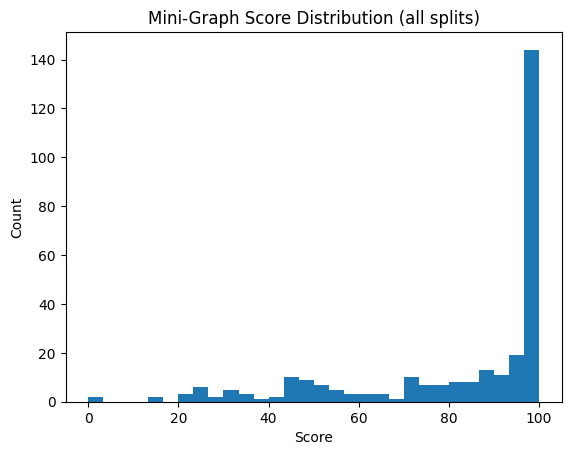

Summary by split:
            count       mean        std   min   10%   25%    50%    75%    90%    95%    max
split                                                                                       
test         58.0  82.051724  23.949085   0.0  45.4  70.0   91.0  100.0  100.0  100.0  100.0
train       152.0  77.625000  25.932110   1.0  32.2  59.5   88.0   97.0  100.0  100.0  100.0
validation   84.0  90.357143  18.920024  24.0  50.0  94.0  100.0  100.0  100.0  100.0  100.0

Top 50 by score (across all splits):


,split,row_idx,score,contract_id,clause_id,prompt_json,completion_json,report
293,test,57,100.0,StaarSurgicalCompany_20180801_10-Q_EX-10.37_11...,17,"{""instruction"":""\nYour task is to act as a leg...","{""contract_id"":""StaarSurgicalCompany_20180801_...","{'penalties': {}, 'counts': {'nodes_in': 16, '..."
292,test,56,100.0,StaarSurgicalCompany_20180801_10-Q_EX-10.37_11...,4.2,"{""instruction"":""\nYour task is to act as a leg...","{""contract_id"":""StaarSurgicalCompany_20180801_...","{'penalties': {}, 'counts': {'nodes_in': 7, 'n..."
1,train,1,100.0,"NETGEAR,INC_04_21_2003-EX-10.16-DISTRIBUTOR AG...",16,"{""instruction"":""\nYour task is to act as a leg...","{""contract_id"":""NETGEAR,INC_04_21_2003-EX-10.1...","{'penalties': {}, 'counts': {'nodes_in': 9, 'n..."
273,test,37,100.0,StaarSurgicalCompany_20180801_10-Q_EX-10.37_11...,16.6,"{""instruction"":""\nYour task is to act as a leg...","{""contract_id"":""StaarSurgicalCompany_20180801_...","{'penalties': {}, 'counts': {'nodes_in': 4, 'n..."
270,test,34,100.0,StaarSurgicalCompany_20180801_10-Q_EX-10.37_11...,20,"{""instruction"":""\nYour task is to act as a leg...","{""contract_id"":""StaarSurgicalCompany_20180801_...","{'penalties': {}, 'counts': {'nodes_in': 4, 'n..."
269,test,33,100.0,StaarSurgicalCompany_20180801_10-Q_EX-10.37_11...,26,"{""instruction"":""\nYour task is to act as a leg...","{""contract_id"":""StaarSurgicalCompany_20180801_...","{'penalties': {}, 'counts': {'nodes_in': 6, 'n..."
265,test,29,100.0,StaarSurgicalCompany_20180801_10-Q_EX-10.37_11...,1.2,"{""instruction"":""\nYour task is to act as a leg...","{""contract_id"":""StaarSurgicalCompany_20180801_...","{'penalties': {}, 'counts': {'nodes_in': 7, 'n..."
262,test,26,100.0,StaarSurgicalCompany_20180801_10-Q_EX-10.37_11...,10.6,"{""instruction"":""\nYour task is to act as a leg...","{""contract_id"":""StaarSurgicalCompany_20180801_...","{'penalties': {}, 'counts': {'nodes_in': 4, 'n..."
261,test,25,100.0,StaarSurgicalCompany_20180801_10-Q_EX-10.37_11...,22,"{""instruction"":""\nYour task is to act as a leg...","{""contract_id"":""StaarSurgicalCompany_20180801_...","{'penalties': {}, 'counts': {'nodes_in': 8, 'n..."
259,test,23,100.0,StaarSurgicalCompany_20180801_10-Q_EX-10.37_11...,2018,"{""instruction"":""\nYour task is to act as a leg...","{""contract_id"":""StaarSurgicalCompany_20180801_...","{'penalties': {}, 'counts': {'nodes_in': 7, 'n..."



Saved Top-50 CSV → /content/top50_minigraph_scores_ds.csv


In [ ]:
# =====================================================
# Score an entire HF DatasetDict `ds` with JSON strings
# Requires: score_completion(instruction_text, clause, completion)
# Produces: score histogram + Top-50 records across all splits
# =====================================================
import json
import math
from typing import Any, Dict, List
import pandas as pd
import matplotlib.pyplot as plt

# ---- sanity: ensure the scorer exists ----
if 'score_completion' not in globals():
    raise RuntimeError("score_completion(...) not found. Run the scoring cell you pasted earlier.")

def _parse_prompt_json(s: str) -> Dict[str, Any]:
    """
    prompt JSON string -> {"instruction": "...", "input": {"clause": {...}, ...}}
    returns {} on parse failure
    """
    try:
        obj = json.loads(s)
        return obj if isinstance(obj, dict) else {}
    except Exception:
        return {}

def _parse_completion_json(s: str):
    """
    completion JSON string -> dict, but if parse fails returns the raw string.
    (The scorer can handle either.)
    """
    try:
        obj = json.loads(s)
        return obj
    except Exception:
        return s  # scorer's parser can still try to extract JSON from prose

def _iter_splits(ds):
    # Works for DatasetDict or single Dataset
    try:
        for split_name in ds.keys():  # DatasetDict
            yield split_name, ds[split_name]
    except Exception:
        yield "train", ds  # single split

def score_dataset(ds) -> pd.DataFrame:
    records: List[Dict[str, Any]] = []

    for split_name, dset in _iter_splits(ds):
        # HF Dataset is iterable: each row is a dict
        for idx, row in enumerate(dset):
            p_raw = row.get("prompt", "")
            c_raw = row.get("completion", "")

            p = _parse_prompt_json(p_raw)
            instr  = p.get("instruction", "")
            input_ = p.get("input", {}) if isinstance(p.get("input", {}), dict) else {}
            clause = input_.get("clause", {}) if isinstance(input_.get("clause", {}), dict) else {}

            completion = _parse_completion_json(c_raw)

            result = score_completion(instr, clause, completion)  # {"score": float, "report": {...}}

            records.append({
                "split": split_name,
                "row_idx": idx,
                "contract_id": input_.get("contract_id", ""),
                "clause_id": clause.get("id", ""),
                "score": result["score"],
                "report": result["report"],
                "prompt_json": p_raw,        # keep raw for inspection if needed
                "completion_json": c_raw     # keep raw for inspection if needed
            })

    return pd.DataFrame.from_records(records)

# ---- Run the scorer on your whole `ds` ----
df_scored = score_dataset(ds)

# ---- Distribution (histogram) ----
plt.figure()
df_scored["score"].plot(kind="hist", bins=30)
plt.title("Mini-Graph Score Distribution (all splits)")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

# ---- Summary stats ----
print("Summary by split:")
print(df_scored.groupby("split")["score"].describe(percentiles=[0.1,0.25,0.5,0.75,0.9,0.95]).to_string())

# ---- Top 50 across all splits ----
top50 = df_scored.sort_values("score", ascending=False).head(50)
display_cols = [c for c in [
    "split", "row_idx", "score", "contract_id", "clause_id", "prompt_json", "completion_json", "report"
] if c in top50.columns]

print("\nTop 50 by score (across all splits):")
from IPython.display import display
display(top50[display_cols])

# (optional) save to CSV
csv_path = "/content/top50_minigraph_scores_ds.csv"
top50.to_csv(csv_path, index=False)
print(f"\nSaved Top-50 CSV → {csv_path}")


In [ ]:
# ==========================================
# Batch-score a dataframe of completions
# Requires: score_completion(...) from the earlier cell
# DataFrame requirements:
#   - df['completion']  : str or dict (model output with {"nodes":[], "edges":[]})
#   - Clause info (any of the following forms, the code will auto-detect):
#       * df['clause'] as dict or JSON string with {"id","text",["level"]}
#       * OR df['clause_id'] + df['clause_text'] + optional df['clause_level']
#       * (nice-to-have) df['instruction_text'] or df['prompt'] for logging
# Outputs:
#   - df_scored (new columns: score, report)
#   - Histogram figure
#   - top50_df (+ CSV at /content/top50_minigraph_scores.csv)
# ==========================================
import json, re, math
import pandas as pd
import matplotlib.pyplot as plt
from typing import Any, Dict

# ---- sanity: require earlier scoring cell ----
if 'score_completion' not in globals():
    raise RuntimeError("score_completion(...) not found. Run the scoring cell I provided earlier before this one.")

def _series_get(s: pd.Series, key: str, default=None):
    try:
        val = s.get(key, default)
        return default if (pd.isna(val) if hasattr(pd, 'isna') else val is None) else val
    except Exception:
        return default

def infer_clause_from_row(row: pd.Series) -> Dict[str, Any]:
    """
    Try multiple places to find the clause. Always return a dict with keys: id, text, (optional) level.
    """
    # 1) direct 'clause' column (dict or JSON)
    val = _series_get(row, 'clause', None)
    if isinstance(val, dict):
        clause = {**val}
    elif isinstance(val, str):
        try:
            obj = json.loads(val)
            clause = obj if isinstance(obj, dict) else {}
        except Exception:
            clause = {}
    else:
        clause = {}

    # 2) fallbacks: separate columns
    if not clause:
        cid   = _series_get(row, 'clause_id', _series_get(row, 'id', ''))
        ctext = _series_get(row, 'clause_text', _series_get(row, 'text', ''))
        lvl   = _series_get(row, 'clause_level', _series_get(row, 'level', None))
        clause = {"id": str(cid or ""), "text": str(ctext or ""), "level": lvl}

    # normalize keys
    clause.setdefault('id', str(_series_get(row, 'clause_id', '')))
    clause.setdefault('text', str(_series_get(row, 'clause_text', '')))
    return clause

def infer_instruction_from_row(row: pd.Series) -> str:
    for k in ('instruction_text','instruction','prompt','system_prompt','task'):
        val = _series_get(row, k, None)
        if isinstance(val, str) and val.strip():
            return val
    return ""

def safe_completion_cell(val):
    # Scorer already accepts dict or str (and can extract JSON from prose).
    return val

# -------- main loop over df --------
def score_dataframe(df: pd.DataFrame, completion_col: str = 'completion') -> pd.DataFrame:
    scores   = []
    reports  = []

    for idx, row in df.iterrows():
        clause = infer_clause_from_row(row)
        instr  = infer_instruction_from_row(row)
        comp   = safe_completion_cell(row[completion_col])

        result = score_completion(instr, clause, comp)  # returns {"score": float, "report": {...}}
        scores.append(result["score"])
        reports.append(result["report"])

    df_scored = df.copy()
    df_scored["score"]  = scores
    df_scored["report"] = reports
    return df_scored

# ---- run on your df ----
df_scored = score_dataframe(df, completion_col='completion')  # adjust name if different

# ---- distribution (histogram) ----
plt.figure()
df_scored["score"].plot(kind="hist", bins=30)
plt.title("Mini-Graph Score Distribution")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

# ---- summary stats ----
summary = df_scored["score"].describe(percentiles=[0.1,0.25,0.5,0.75,0.9,0.95])
print("Summary:\n", summary.to_string())

# ---- Top 50 ----
top50_df = df_scored.sort_values("score", ascending=False).head(50)

# pick a compact set of columns to show if available
display_cols = [c for c in [
    "score",
    "contract_id",
    "clause_id", "clause_text", "clause_level",
    "clause",            # dict form
    "completion",        # model output (str or dict)
    "report"             # diagnostics
] if c in top50_df.columns]

from IPython.display import display
print("\nTop 50 by score:")
display(top50_df[display_cols] if display_cols else top50_df.head(50))

# save to CSV for tooling
csv_path = "/content/top50_minigraph_scores.csv"
top50_df.to_csv(csv_path, index=False)
print(f"\nSaved: {csv_path}")


In [ ]:

print(score_grpo_group("instr", clause, [completion, {"nodes":[], "edges":[]}]))


{'items': [{'idx': 0, 'score': 94.0, 'reward': 1.0, 'report': {'penalties': {'spurious_defines': -6.0}, 'counts': {'nodes_in': 18, 'nodes_dedup': 18, 'edges_in': 17, 'edges_norm': 17, 'edges_kept': 17, 'illegal_edges': 0}, 'triggers': {'parent': True, 'references': True, 'defines': True, 'uses': True, 'parties': False, 'values': False, 'party_hits': 0, 'value_hits': 0, 'use_hits': 4, 'ref_hits': 2}}}, {'idx': 1, 'score': 0.0, 'reward': 0.0, 'report': {'penalties': {'catastrophic_empty': -90, 'missing_contract_id': -5, 'missing_clause_node': -20, 'missing_parent_is_part_of': -15, 'recall_misses': -18.0}, 'counts': {'nodes_in': 0, 'nodes_dedup': 0, 'edges_in': 0, 'edges_norm': 0, 'edges_kept': 0, 'illegal_edges': 0}, 'triggers': {'parent': True, 'references': True, 'defines': True, 'uses': True, 'parties': False, 'values': False, 'party_hits': 0, 'value_hits': 0, 'use_hits': 4, 'ref_hits': 2}}}], 'best_idx': 0}


[Reorg] Moved 2367 files into per-contract folders.
[Step 1] Moved 308 empty-edge pair files to: /content/drive/MyDrive/sft_pairs_grok_debug/pairs/_empty_edges


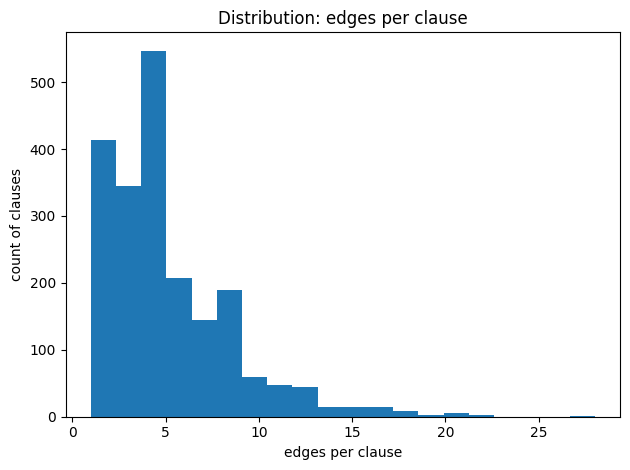

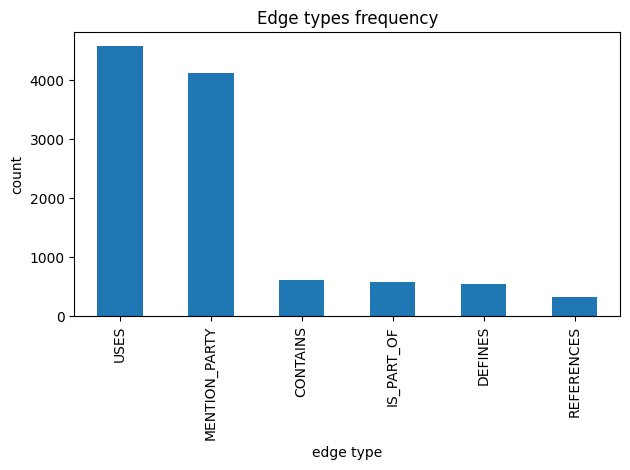

[Step 2] Wrote analytics to: /content/drive/MyDrive/sft_pairs_grok_debug/pairs/_reports
[Info] Contracts with empties: ['ACCURAYINC_09_01_2010-EX-10.31-DISTRIBUTOR AGREEMENT', 'ADAMSGOLFINC_03_21_2005-EX-10.17-ENDORSEMENT AGREEMENT', 'ADIANUTRITION,INC_04_01_2005-EX-10.D2-RESELLER AGREEMENT', 'AIRSPANNETWORKSINC_04_11_2000-EX-10.5-Distributor Agreement', 'AIRTECHINTERNATIONALGROUPINC_05_08_2000-EX-10.4-FRANCHISE AGREEMENT', 'ASIANDRAGONGROUPINC_08_11_2005-EX-10.5-Reseller Agreement', 'AgapeAtpCorp_20191202_10-KA_EX-10.1_11911128_EX-10.1_Supply Agreement', 'AudibleInc_20001113_10-Q_EX-10.32_2599586_EX-10.32_Co-Branding Agreement_ Marketing Agreement_ Investment Distribution Agreement', 'BELLICUMPHARMACEUTICALS,INC_05_07_2019-EX-10.1-Supply Agreement', 'BELLRINGBRANDS,INC_02_07_2020-EX-10.18-MASTER SUPPLY AGREEMENT', 'BIOFRONTERAAG_04_29_2019-EX-4.17-SUPPLY AGREEMENT', 'BravatekSolutionsInc_20170418_8-K_EX-10.1_10205739_EX-10.1_Reseller Agreement', 'Columbia Laboratories, (Bermuda) Ltd. 

[WARN] No node_map for BLACKBOXSTOCKSINC_08_05_2014-EX-10.1-DISTRIBUTOR AGREEMENT; skipping full graph.
[WARN] No node_map for ENTERTAINMENTGAMINGASIAINC_02_15_2005-EX-10.5-DISTRIBUTOR AGREEMENT; skipping full graph.
[WARN] No node_map for InnerscopeHearingTechnologiesInc_20181109_8-K_EX-10.6_11419704_EX-10.6_Distributor Agreement; skipping full graph.
[WARN] No node_map for LEGACYTECHNOLOGYHOLDINGS,INC_12_09_2005-EX-10.2-DISTRIBUTOR AGREEMENT; skipping full graph.


[Step 3] Built 0 full graphs.


[WARN] No node_map for LUCIDINC_04_15_2011-EX-10.9-DISTRIBUTOR AGREEMENT; skipping full graph.


KeyError: 'edges_directed_typed'

In [ ]:
# ======================================================================
# Pair post-processing pipeline (with flat → per-contract reorg)
# ======================================================================
!pip install --quiet networkx matplotlib pandas

import json, os, sys, re, shutil
from pathlib import Path
from collections import Counter, defaultdict

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# -------------------------------
# PATHS — adjust if needed
# -------------------------------
DRIVE_ROOT = Path("/content/drive/MyDrive")

PAIRS_DIR = DRIVE_ROOT / "sft_minigraph_openai_full_alt_test/v4/pairs"            # flat folder with *.json
NODE_MAPS_DIR = DRIVE_ROOT / "sft_minigraph" # *unique.json live here
EMPTY_OUT_DIR = PAIRS_DIR / "_empty_edges"                            # where empties will be moved
FULL_GRAPHS_OUT = PAIRS_DIR                                         # fullgraph jsons saved here (root)
REPORTS_OUT = PAIRS_DIR / "_reports"                                  # CSVs + plots

EMPTY_OUT_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_OUT.mkdir(parents=True, exist_ok=True)

# -------------------------------
# (0) One-time reorg: flat → per-contract subfolders
# Rule: filename is "<contract_id>__<whatever>.json"
# -------------------------------
def reorganize_pairs_by_contract(pairs_dir: Path):
    moved = 0
    for f in pairs_dir.glob("*.json"):
        if not f.is_file():
            continue
        name = f.name
        if name.startswith("_"):  # skip logs etc.
            continue
        if "__" not in name:
            # already inside a contract folder? skip if so
            if f.parent != pairs_dir:
                continue
            print(f"[WARN] Skipping (no '__' found): {name}", file=sys.stderr)
            continue
        contract_id = name.split("__", 1)[0]
        dest_dir = pairs_dir / contract_id
        dest_dir.mkdir(exist_ok=True)
        dest = dest_dir / name
        if dest.exists():
            continue
        shutil.move(str(f), str(dest))
        moved += 1
    print(f"[Reorg] Moved {moved} files into per-contract folders.")

reorganize_pairs_by_contract(PAIRS_DIR)

# -------------------------------
# Helpers
# -------------------------------
def walk_pair_files(pairs_dir: Path):
    """Yield (contract_id, file_path) for *.json files under pairs_dir/<contract_id>/."""
    for contract_dir in sorted(pairs_dir.iterdir()):
        if not contract_dir.is_dir() or contract_dir.name.startswith("_"):
            continue
        contract_id = contract_dir.name
        for f in sorted(contract_dir.glob("*.json")):
            if f.is_file():
                yield contract_id, f

def read_json(path: Path):
    try:
        with open(path, "r", encoding="utf-8") as f:
            return json.load(f)
    except Exception as e:
        print(f"[WARN] Failed to read {path.name}: {e}", file=sys.stderr)
        return None

def write_json(path: Path, obj):
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, indent=2, ensure_ascii=False)

def load_unique_node_map_for(contract_id: str):
    """
    Load the lean node map for a given contract_id from *unique.json files.
    Each file: {"contract_id":"...", "nodes":[...]}
    """
    # Prefer filename match
    for p in NODE_MAPS_DIR.glob(f"*{contract_id}*unique.json"):
        data = read_json(p)
        if data and data.get("contract_id") == contract_id and isinstance(data.get("nodes"), list):
            return data["nodes"]
    # Fallback: scan all
    for p in NODE_MAPS_DIR.glob("*unique.json"):
        data = read_json(p)
        if data and data.get("contract_id") == contract_id and isinstance(data.get("nodes"), list):
            return data["nodes"]
    return []

def dedup_edges(edge_list):
    """Unique by (src,tgt,type) keeping first occurrence."""
    seen = set()
    out = []
    for e in edge_list or []:
        src, tgt, et = e.get("src"), e.get("tgt"), e.get("type")
        if not src or not tgt or not et:
            continue
        key = (src, tgt, et)
        if key not in seen:
            seen.add(key)
            out.append({"src": src, "tgt": tgt, "type": et})
    return out

def make_undirected_simple_edges(edge_list):
    """Collapse to undirected simple edges for structural metrics."""
    undirected = set()
    for e in edge_list or []:
        s, t = e.get("src"), e.get("tgt")
        if not s or not t:
            continue
        a, b = (s, t) if s <= t else (t, s)
        undirected.add((a, b))
    return list(undirected)

def graph_metrics(node_ids, edge_list):
    """
    Metrics on undirected simple graph:
      nodes, edges_directed_typed, edges_undirected, density,
      orphans, leaves, orphan_ratio, leaf_ratio,
      articulation_points, dependency_depth (max component diameter), k_core_k
    """
    node_ids = set(node_ids or [])
    for e in edge_list or []:
        node_ids.add(e["src"]); node_ids.add(e["tgt"])

    undirected_edges = make_undirected_simple_edges(edge_list)
    G = nx.Graph()
    G.add_nodes_from(node_ids)
    G.add_edges_from(undirected_edges)

    n = G.number_of_nodes()
    m_undir = G.number_of_edges()
    m_directed_typed = len(dedup_edges(edge_list))
    density = nx.density(G) if n > 1 else 0.0

    deg = dict(G.degree())
    orphans = [u for u, d in deg.items() if d == 0]
    leaves = [u for u, d in deg.items() if d == 1]
    orphan_ratio = (len(orphans) / n) if n else 0.0
    leaf_ratio = (len(leaves) / n) if n else 0.0

    articulation = list(nx.articulation_points(G)) if n > 0 else []

    diameter = 0
    if n > 0 and m_undir > 0:
        for comp_nodes in nx.connected_components(G):
            if len(comp_nodes) == 1:
                continue
            sub = G.subgraph(comp_nodes)
            try:
                d = nx.diameter(sub)
            except nx.NetworkXError:
                d = 0
            diameter = max(diameter, d)

    try:
        core_num = nx.core_number(G) if n > 0 else {}
        k_core_k = max(core_num.values()) if core_num else 0
    except nx.NetworkXError:
        k_core_k = 0

    return {
        "nodes": n,
        "edges_directed_typed": m_directed_typed,
        "edges_undirected": m_undir,
        "density": density,
        "orphans": len(orphans),
        "leaves": len(leaves),
        "orphan_ratio": orphan_ratio,
        "leaf_ratio": leaf_ratio,
        "articulation_points": len(articulation),
        "dependency_depth": diameter,
        "k_core_k": k_core_k
    }

# ======================================================================
# (1) Move empty-edge pairs into _empty_edges/<contract_id>/…
# ======================================================================
moved = []
kept = []
for contract_id, f in walk_pair_files(PAIRS_DIR):
    data = read_json(f)
    if not data or "completion" not in data:
        continue
    edges = (data.get("completion") or {}).get("edges")
    if isinstance(edges, list) and len(edges) == 0:
        dest_dir = EMPTY_OUT_DIR / contract_id
        dest_dir.mkdir(parents=True, exist_ok=True)
        dest = dest_dir / f.name
        try:
            shutil.move(str(f), str(dest))
            moved.append(str(dest))
        except Exception as e:
            print(f"[WARN] Could not move {f} → {dest}: {e}", file=sys.stderr)
    else:
        kept.append((contract_id, f))

print(f"[Step 1] Moved {len(moved)} empty-edge pair files to: {EMPTY_OUT_DIR}")
write_json(REPORTS_OUT / "moved_empty_pairs.json", {"moved_files": moved})

# ======================================================================
# (2) Edge analytics: per-clause counts + distribution plots
# ======================================================================
records = []
edge_type_counter = Counter()
for contract_id, f in kept:
    data = read_json(f)
    if not data:
        continue
    # Extract clause id from the part after contract_id; assume filename "<contract_id>__<clauseId or label>__*.json"
    fname_parts = f.name.split("__")
    clause_id = fname_parts[1] if len(fname_parts) > 1 else None

    edges = (data.get("completion") or {}).get("edges") or []
    records.append({
        "contract_id": contract_id,
        "clause_id": clause_id,
        "file": str(f),
        "edge_count": len(edges)
    })
    for e in edges:
        et = e.get("type")
        if et:
            edge_type_counter[et] += 1

df_edges = pd.DataFrame(records)
write_json(REPORTS_OUT / "edge_clause_counts.json", json.loads(df_edges.to_json(orient="records")))

plt.figure()
df_edges["edge_count"].plot(kind="hist", bins=20, title="Distribution: edges per clause")
plt.xlabel("edges per clause")
plt.ylabel("count of clauses")
plt.tight_layout()
plt.savefig(REPORTS_OUT / "edges_per_clause_hist.png")
plt.show()

plt.figure()
types_series = pd.Series(edge_type_counter).sort_values(ascending=False)
types_series.plot(kind="bar", title="Edge types frequency")
plt.xlabel("edge type")
plt.ylabel("count")
plt.tight_layout()
plt.savefig(REPORTS_OUT / "edge_types_bar.png")
plt.show()

df_edges.to_csv(REPORTS_OUT / "edge_clause_counts.csv", index=False)
pd.DataFrame(types_series, columns=["count"]).to_csv(REPORTS_OUT / "edge_type_counts.csv")

print(f"[Step 2] Wrote analytics to: {REPORTS_OUT}")

# ======================================================================
# (3) Build full graphs for contracts with NO empties
# ======================================================================
contracts_with_empties = {Path(p).parent.name for p in moved}
print(f"[Info] Contracts with empties: {sorted(contracts_with_empties)}")

by_contract = defaultdict(list)
for contract_id, f in kept:
    by_contract[contract_id].append(f)

fullgraph_manifests = []
for contract_id, files in by_contract.items():
    if contract_id in contracts_with_empties:
        continue

    all_edges = []
    for f in files:
        data = read_json(f)
        if not data:
            continue
        all_edges.extend((data.get("completion") or {}).get("edges") or [])
    deduped = dedup_edges(all_edges)

    node_map = load_unique_node_map_for(contract_id)
    if not node_map:
        print(f"[WARN] No node_map for {contract_id}; skipping full graph.", file=sys.stderr)
        continue

    full_graph = {
        "contract_id": contract_id,
        "node_map": node_map,
        "edges": deduped
    }
    out_path = FULL_GRAPHS_OUT / f"{contract_id}_fullgraph.json"
    write_json(out_path, full_graph)
    fullgraph_manifests.append((contract_id, str(out_path)))

print(f"[Step 3] Built {len(fullgraph_manifests)} full graphs.")
write_json(REPORTS_OUT / "fullgraphs_manifest.json", {"fullgraphs": fullgraph_manifests})

# ======================================================================
# (4) Summary metrics over full graphs
# ======================================================================
metrics_rows = []
for contract_id, path_str in fullgraph_manifests:
    data = read_json(Path(path_str))
    if not data:
        continue
    nodes = [n.get("id") for n in (data.get("node_map") or []) if n.get("id")]
    edges = data.get("edges") or []
    m = graph_metrics(nodes, edges)
    m["contract_id"] = contract_id
    m["fullgraph_file"] = path_str
    metrics_rows.append(m)

df_metrics = pd.DataFrame(metrics_rows).sort_values(by="edges_directed_typed", ascending=False)
df_metrics.to_csv(REPORTS_OUT / "fullgraphs_metrics.csv", index=False)
write_json(REPORTS_OUT / "fullgraphs_metrics.json", json.loads(df_metrics.to_json(orient="records")))

print(f"[Step 4] Metrics computed for {len(df_metrics)} contracts.")
display_cols = ["contract_id","nodes","edges_directed_typed","edges_undirected","density","orphans","leaves","orphan_ratio","leaf_ratio","articulation_points","dependency_depth","k_core_k","fullgraph_file"]
print(df_metrics[display_cols].head(20))

plt.figure()
df_metrics.set_index("contract_id")["edges_directed_typed"].plot(kind="bar", title="Edges per contract (full graphs)")
plt.ylabel("# edges (directed, typed, deduped)")
plt.tight_layout()
plt.savefig(REPORTS_OUT / "fullgraphs_edges_per_contract.png")
plt.show()

print("\nOutputs:")
print(" - Empty-edge files moved under:", EMPTY_OUT_DIR)
print(" - Edge analytics CSVs/plots in:", REPORTS_OUT)
print(" - Full graphs saved as *_fullgraph.json in:", FULL_GRAPHS_OUT)
print(" - Full graph metrics CSV:", REPORTS_OUT / "fullgraphs_metrics.csv")


In [ ]:
# ======================================================================
# Post-processing: edge-linker SFT pairs → QA, analytics, full graphs, metrics
# ======================================================================
!pip install --quiet networkx matplotlib pandas

import json, os, sys, re, shutil
from pathlib import Path
from collections import Counter, defaultdict

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# -------------------------------
# CONFIG — adjust if needed
# -------------------------------
DRIVE_ROOT = Path("/content/drive/MyDrive")

PAIRS_DIR = DRIVE_ROOT / "sft_phase2_xai_edge_extraction"            # where per-clause pair files live (subfolders by contract_id)
NODE_MAPS_DIR = DRIVE_ROOT / "sft_phase2_xai_edge_extraction_context" # has *unique.json per contract
EMPTY_OUT_DIR = PAIRS_DIR / "_empty_edges"                            # moved-empty pairs for manual review
FULL_GRAPHS_OUT = PAIRS_DIR                                           # fullgraph jsons saved in this root (as requested)
REPORTS_OUT = PAIRS_DIR / "_reports"                                  # CSVs + plots

EMPTY_OUT_DIR.mkdir(parents=True, exist_ok=True)
REPORTS_OUT.mkdir(parents=True, exist_ok=True)

# -------------------------------
# Helpers
# -------------------------------

def walk_pair_files(pairs_dir: Path):
    """Yield (contract_id, file_path) for edges_*.json files under pairs_dir/<contract_id>/."""
    for contract_dir in sorted(pairs_dir.iterdir()):
        if not contract_dir.is_dir() or contract_dir.name.startswith("_"):
            continue
        contract_id = contract_dir.name
        for f in sorted(contract_dir.glob("edges_*.json")):
            if f.is_file():
                yield contract_id, f

def read_json(path: Path):
    try:
        with open(path, "r", encoding="utf-8") as f:
            return json.load(f)
    except Exception as e:
        print(f"[WARN] Failed to read {path.name}: {e}", file=sys.stderr)
        return None

def write_json(path: Path, obj):
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(obj, f, indent=2, ensure_ascii=False)

def load_unique_node_map_for(contract_id: str):
    """
    Load the lean node map for a given contract_id from *unique.json files.
    Each file looks like: {"contract_id": "...", "nodes": [...]}
    """
    # filename includes contract_id
    for p in NODE_MAPS_DIR.glob(f"*{contract_id}*unique.json"):
        data = read_json(p)
        if data and data.get("contract_id") == contract_id and isinstance(data.get("nodes"), list):
            return data["nodes"]
    # fallback: scan all
    for p in NODE_MAPS_DIR.glob("*unique.json"):
        data = read_json(p)
        if data and data.get("contract_id") == contract_id and isinstance(data.get("nodes"), list):
            return data["nodes"]
    return []

def dedup_edges(edge_list):
    """Return list of unique edges by (src, tgt, type) while preserving first-seen order."""
    seen = set()
    out = []
    for e in edge_list or []:
        src, tgt, et = e.get("src"), e.get("tgt"), e.get("type")
        if not src or not tgt or not et:
            continue
        key = (src, tgt, et)
        if key not in seen:
            seen.add(key)
            out.append({"src": src, "tgt": tgt, "type": et})
    return out

def make_undirected_simple_edges(edge_list):
    """Collapse directed/typed edges to simple undirected pairs for structural metrics."""
    undirected = set()
    for e in edge_list or []:
        s, t = e.get("src"), e.get("tgt")
        if not s or not t:
            continue
        a, b = (s, t) if s <= t else (t, s)
        undirected.add((a, b))
    return list(undirected)

def graph_metrics(node_ids, edge_list):
    """
    Compute metrics on an undirected simple graph:
      - nodes, edges (directed unique typed), edges_undirected
      - density
      - orphans, leaves, orphan_ratio, leaf_ratio
      - articulation_points
      - dependency_depth (as diameter of largest component)
      - k_core_k (max core number)
    """
    node_ids = set(node_ids or [])
    # Add missing nodes referenced by edges so they count in connectivity/metrics
    for e in edge_list or []:
        node_ids.add(e["src"])
        node_ids.add(e["tgt"])

    undirected_edges = make_undirected_simple_edges(edge_list)
    G = nx.Graph()
    G.add_nodes_from(node_ids)
    G.add_edges_from(undirected_edges)

    n = G.number_of_nodes()
    m_undir = G.number_of_edges()
    m_directed_typed = len(dedup_edges(edge_list))

    density = nx.density(G) if n > 1 else 0.0

    deg = dict(G.degree())
    orphans = [u for u, d in deg.items() if d == 0]
    leaves = [u for u, d in deg.items() if d == 1]
    orphan_ratio = (len(orphans) / n) if n else 0.0
    leaf_ratio = (len(leaves) / n) if n else 0.0

    # Articulation points
    articulation = list(nx.articulation_points(G)) if n > 0 else []

    # Dependency depth → use graph diameter of each connected component; take max
    diameter = 0
    if n > 0 and m_undir > 0:
        for comp_nodes in nx.connected_components(G):
            if len(comp_nodes) == 1:
                continue
            sub = G.subgraph(comp_nodes)
            try:
                d = nx.diameter(sub)
            except nx.NetworkXError:
                # If not connected (shouldn't happen per component), skip
                d = 0
            diameter = max(diameter, d)

    # k-core
    try:
        core_num = nx.core_number(G) if n > 0 else {}
        k_core_k = max(core_num.values()) if core_num else 0
    except nx.NetworkXError:
        k_core_k = 0

    return {
        "nodes": n,
        "edges_directed_typed": m_directed_typed,
        "edges_undirected": m_undir,
        "density": density,
        "orphans": len(orphans),
        "leaves": len(leaves),
        "orphan_ratio": orphan_ratio,
        "leaf_ratio": leaf_ratio,
        "articulation_points": len(articulation),
        "dependency_depth": diameter,
        "k_core_k": k_core_k
    }



In [ ]:
# ======================================================================
# (1) Move empty-edge pairs into _empty_edges/<contract_id>/…
# ======================================================================
moved = []
kept = []
for contract_id, f in walk_pair_files(PAIRS_DIR):
    data = read_json(f)
    if not data or "completion" not in data:
        continue
    edges = (data.get("completion") or {}).get("edges")
    if isinstance(edges, list) and len(edges) == 0:
        dest_dir = EMPTY_OUT_DIR / contract_id
        dest_dir.mkdir(parents=True, exist_ok=True)
        dest = dest_dir / f.name
        try:
            shutil.move(str(f), str(dest))
            moved.append(str(dest))
        except Exception as e:
            print(f"[WARN] Could not move {f} → {dest}: {e}", file=sys.stderr)
    else:
        kept.append((contract_id, f))

print(f"[Step 1] Moved {len(moved)} empty-edge pair files to: {EMPTY_OUT_DIR}")
# Optional: write a log of moved files
write_json(REPORTS_OUT / "moved_empty_pairs.json", {"moved_files": moved})


In [ ]:

# ======================================================================
# (2) Edge analytics: per-clause counts and distribution plots
# ======================================================================
records = []
edge_type_counter = Counter()
for contract_id, f in kept:
    data = read_json(f)
    if not data:
        continue
    # Try to recover clause id from filename: edges_<clauseId>_...
    m = re.match(r"edges_(.+?)_", f.name)
    clause_id = m.group(1) if m else None
    edges = (data.get("completion") or {}).get("edges") or []
    # Count
    records.append({
        "contract_id": contract_id,
        "clause_id": clause_id,
        "file": str(f),
        "edge_count": len(edges)
    })
    # per type
    for e in edges:
        et = e.get("type")
        if et:
            edge_type_counter[et] += 1

df_edges = pd.DataFrame(records)
write_json(REPORTS_OUT / "edge_clause_counts.json", json.loads(df_edges.to_json(orient="records")))

# Histogram: edges per clause
plt.figure()
df_edges["edge_count"].plot(kind="hist", bins=20, title="Distribution: edges per clause")
plt.xlabel("edges per clause")
plt.ylabel("count of clauses")
plt.tight_layout()
plt.savefig(REPORTS_OUT / "edges_per_clause_hist.png")
plt.show()

# Bar: edge types frequency
plt.figure()
types_series = pd.Series(edge_type_counter).sort_values(ascending=False)
types_series.plot(kind="bar", title="Edge types frequency")
plt.xlabel("edge type")
plt.ylabel("count")
plt.tight_layout()
plt.savefig(REPORTS_OUT / "edge_types_bar.png")
plt.show()

# Also save a CSV for convenient viewing
df_edges.to_csv(REPORTS_OUT / "edge_clause_counts.csv", index=False)
pd.DataFrame(types_series, columns=["count"]).to_csv(REPORTS_OUT / "edge_type_counts.csv")

print(f"[Step 2] Wrote analytics to: {REPORTS_OUT}")



In [ ]:
# ======================================================================
# (3) Build full graphs (only for contracts with NO empty-edge pairs)
# ======================================================================
# Contracts that had any empty files are in moved paths:
contracts_with_empties = {Path(p).parent.name for p in moved}
print(f"[Info] Contracts with empties: {sorted(contracts_with_empties)}")

# Group kept pair files by contract
by_contract = defaultdict(list)
for contract_id, f in kept:
    by_contract[contract_id].append(f)

fullgraph_manifests = []  # list of produced files (contract_id, path)
for contract_id, files in by_contract.items():
    if contract_id in contracts_with_empties:
        continue  # skip per requirement

    # Merge & dedup all edges
    all_edges = []
    for f in files:
        data = read_json(f)
        if not data:
            continue
        edges = (data.get("completion") or {}).get("edges") or []
        all_edges.extend(edges)
    deduped = dedup_edges(all_edges)

    # Load node map
    node_map = load_unique_node_map_for(contract_id)
    if not node_map:
        print(f"[WARN] No node_map for {contract_id}; skipping full graph.", file=sys.stderr)
        continue

    full_graph = {
        "contract_id": contract_id,
        "node_map": node_map,
        "edges": deduped
    }
    out_path = FULL_GRAPHS_OUT / f"{contract_id}_fullgraph.json"
    write_json(out_path, full_graph)
    fullgraph_manifests.append((contract_id, str(out_path)))

print(f"[Step 3] Built {len(fullgraph_manifests)} full graphs.")
write_json(REPORTS_OUT / "fullgraphs_manifest.json", {"fullgraphs": fullgraph_manifests})


In [ ]:

# ======================================================================
# (4) Summary report on full graphs + metrics
# ======================================================================
metrics_rows = []
for contract_id, path_str in fullgraph_manifests:
    data = read_json(Path(path_str))
    if not data:
        continue
    nodes = [n.get("id") for n in (data.get("node_map") or []) if n.get("id")]
    edges = data.get("edges") or []
    m = graph_metrics(nodes, edges)
    m["contract_id"] = contract_id
    m["fullgraph_file"] = path_str
    metrics_rows.append(m)

df_metrics = pd.DataFrame(metrics_rows).sort_values(by="edges_directed_typed", ascending=False)
df_metrics.to_csv(REPORTS_OUT / "fullgraphs_metrics.csv", index=False)
write_json(REPORTS_OUT / "fullgraphs_metrics.json", json.loads(df_metrics.to_json(orient="records")))

print(f"[Step 4] Metrics computed for {len(df_metrics)} contracts.")
display_cols = ["contract_id","nodes","edges_directed_typed","edges_undirected","density","orphans","leaves","orphan_ratio","leaf_ratio","articulation_points","dependency_depth","k_core_k","fullgraph_file"]
print(df_metrics[display_cols].head(20))

# Optional: a quick plot of edges per contract in full graphs
plt.figure()
df_metrics.set_index("contract_id")["edges_directed_typed"].plot(kind="bar", title="Edges per contract (full graphs)")
plt.ylabel("# edges (directed, typed, deduped)")
plt.tight_layout()
plt.savefig(REPORTS_OUT / "fullgraphs_edges_per_contract.png")
plt.show()

print("\nOutputs:")
print(" - Moved empties log:", REPORTS_OUT / "moved_empty_pairs.json")
print(" - Edge analytics CSVs/plots in:", REPORTS_OUT)
print(" - Full graphs saved as *_fullgraph.json in:", FULL_GRAPHS_OUT)
print(" - Full graph metrics CSV:", REPORTS_OUT / "fullgraphs_metrics.csv")


comp {'edges': [{'from': '1.2', 'to': 'term:Agreement', 'type': 'USES'}, {'from': '1.2', 'to': 'term:Airspan Products', 'type': 'USES'}, {'from': '1.2', 'to': 'term:Territory', 'type': 'USES'}, {'from': '1.2', 'to': 'party:Distributor', 'type': 'MENTION_PARTY'}, {'from': '1.2', 'to': 'party:Airspan', 'type': 'MENTION_PARTY'}, {'from': '1.2', 'to': 'party:the parties', 'type': 'MENTION_PARTY'}]}
comp {'edges': [{'from': '1.3', 'to': 'party:Distributor', 'type': 'MENTION_PARTY'}, {'from': '1.3', 'to': 'party:Airspan', 'type': 'MENTION_PARTY'}, {'from': '1.3', 'to': 'term:Airspan Products', 'type': 'USES'}, {'from': '1.3', 'to': 'term:Territory', 'type': 'USES'}, {'from': '1.3', 'to': 'term:Agreement', 'type': 'USES'}, {'from': '1.3', 'to': 'value:three (3) months', 'type': 'CONTAINS'}, {'from': '1.3', 'to': 'value:thirty (30) days', 'type': 'CONTAINS'}]}
comp {'edges': [{'from': '1.4', 'to': 'party:Distributor', 'type': 'MENTION_PARTY'}, {'from': '1.4', 'to': 'party:Airspan', 'type': 'ME

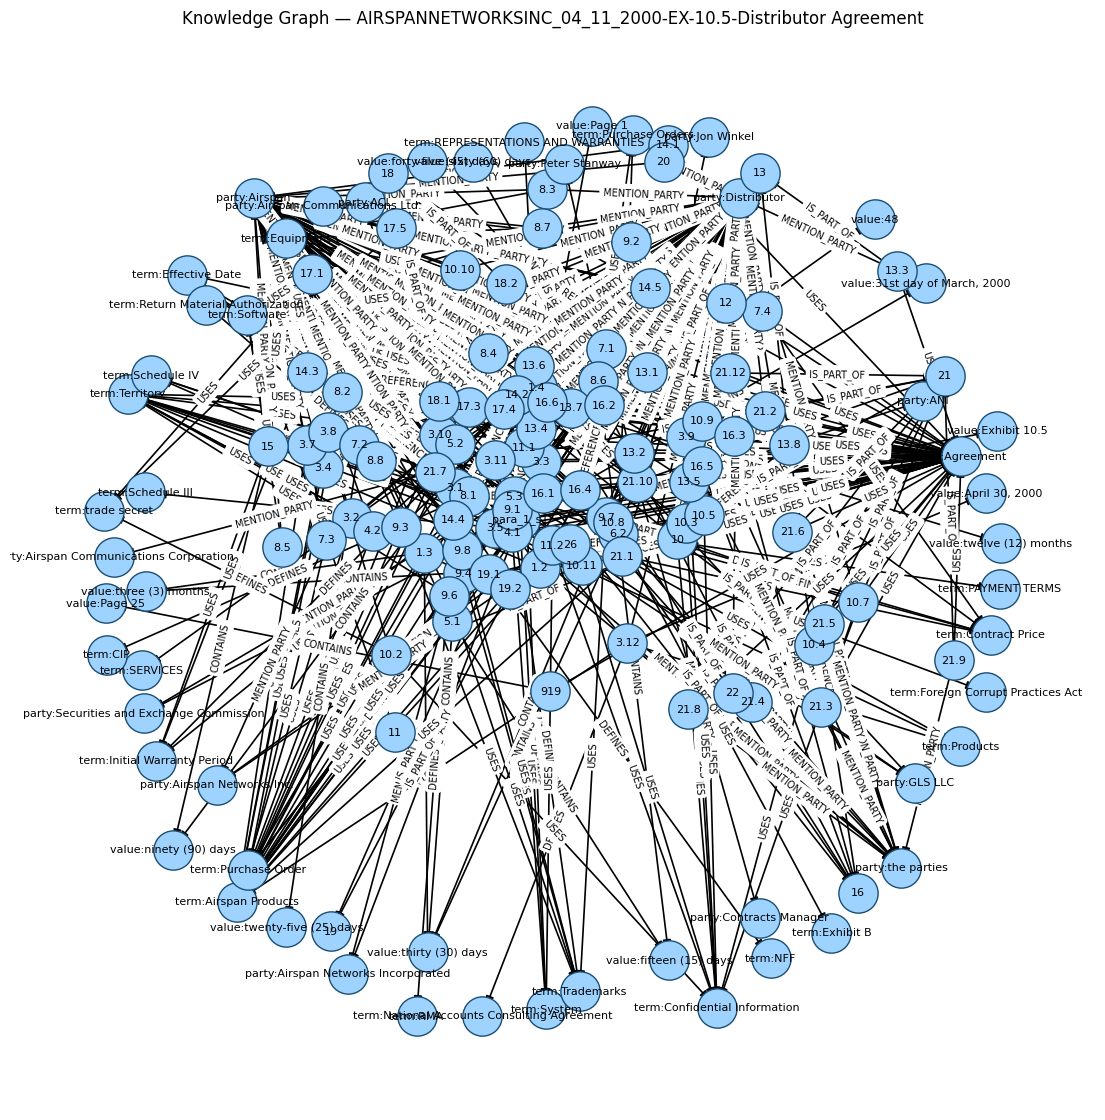

In [ ]:
import json, re
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt

# Adjust these to your notebook paths
OUT_BASE = Path("/content/drive/MyDrive/sft_pairs_grok_debug")  # where your pairs are saved (parent dir)
PAIRS_DIR = OUT_BASE / "pairs"  # or whatever you used in the writer

def _load_edges_for_contract(contract_id: str):
    """Return list of edges for a given contract by reading all pair files and filtering by prompt.contract_id."""
    if not PAIRS_DIR.exists():
        print(f"[WARN] Pairs dir not found: {PAIRS_DIR}")
        return []

    edges = []
    total_files = 0
    matched_files = 0

    for fp in PAIRS_DIR.glob("*.json"):
        #print(f"in fp: {fp}")
        total_files += 1
        try:
            with open(fp, "r", encoding="utf-8") as f:
                data = json.load(f)
                #print(f"in fp: {fp}")
        except Exception as e:
            print(f"[SKIP] {fp.name}: can't read JSON ({e})")
            continue

        # Robustly find contract id inside the saved pair
        prompt_cid = (
            data.get("prompt", {}).get("contract_id")
            or data.get("prompt", {}).get("input", {}).get("contract_id")
            or data.get("input", {}).get("contract_id")    # in case of different saver
            or data.get("contract_id")                      # last resort
        )

        if prompt_cid != contract_id:
            continue

        matched_files += 1
        comp = data.get("completion") or {}
        print(f"comp {comp}")
        raw_edges = comp.get("edges") or []

        # Normalize schema: support from/to or src/tgt
        for e in raw_edges:
            src = e.get("from") if "from" in e else e.get("src")
            tgt = e.get("to") if "to" in e else e.get("tgt")
            et = e.get("type") or e.get("edge_type") or "EDGE"
            attrs = e.get("attrs") or {}

            if not src or not tgt:
                # skip malformed items
                continue
            edges.append({"src": src, "tgt": tgt, "type": et, "attrs": attrs})

    print(f"[INFO] Scanned files: {total_files}, matched contract files: {matched_files}, edges found: {len(edges)}")
    return edges

def analyze_and_visualize_contract(contract_id: str, figsize=(14, 14), k=0.6, iterations=60):
    """Load, analyze, and visualize the graph for a single contract."""
    edges = _load_edges_for_contract(contract_id)
    if not edges:
        print(f"[RESULT] No edges for contract: {contract_id}")
        return

    G = nx.DiGraph()
    for e in edges:
        G.add_edge(e["src"], e["tgt"], type=e["type"])

    print(f"\n--- Analysis for {contract_id} ---")
    print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

    # Top nodes by degree (quick sanity)
    deg = sorted(G.degree, key=lambda x: x[1], reverse=True)[:10]
    print("Top-degree nodes:", ", ".join(f"{n}({d})" for n, d in deg))

    # Draw
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(G, k=k, iterations=iterations, seed=42)
    nx.draw_networkx_nodes(G, pos, node_size=800, node_color="#9fd3ff", edgecolors="#1b4f72")
    nx.draw_networkx_labels(G, pos, font_size=8)
    nx.draw_networkx_edges(G, pos, arrows=True, arrowstyle="-|>", arrowsize=12, width=1.2)
    edge_labels = nx.get_edge_attributes(G, "type")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

    plt.title(f"Knowledge Graph — {contract_id}")
    plt.axis("off")
    plt.show()

# Example: visualize your known debug contract
DEBUG_CONTRACT_ID = "AIRSPANNETWORKSINC_04_11_2000-EX-10.5-Distributor Agreement"
analyze_and_visualize_contract(DEBUG_CONTRACT_ID)


In [ ]:
# ======================================================================
#  QA and Visualization
# ======================================================================
import networkx as nx
import matplotlib.pyplot as plt

def analyze_and_visualize_contract(contract_id: str):
    """Load, analyze, and visualize the graph for a single contract."""
    edge_files = list((OUT_BASE / "pairs").glob("edges_*.json"))
    if not edge_files:
        print(f"No edge files found for contract {contract_id}")
        return

    G = nx.DiGraph()
    for file_path in edge_files:
        with open(file_path, "r", encoding="utf-8") as f:
            data = json.load(f)
        for edge in data.get("completion", {}).get("edges", []):
            G.add_edge(edge["src"], edge["tgt"], type=edge["type"])

    print(f"\n--- Analysis for {contract_id} ---")
    print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")

    if G.number_of_edges() > 0:
        plt.figure(figsize=(12, 12))
        pos = nx.spring_layout(G, k=0.5, iterations=50)
        nx.draw(G, pos, with_labels=True, node_size=1000, node_color="skyblue", font_size=8)
        edge_labels = nx.get_edge_attributes(G, "type")
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
        plt.title(f"Knowledge Graph for {contract_id}")
        plt.show()

# Example: Analyze the first contract that was processed
try:
    first_contract_id = sorted(PARSED_CONTRACTS_DIR.glob("*.json"))[0].stem
    analyze_and_visualize_contract(first_contract_id)
except IndexError:
    print("No contracts found to analyze.")



No edge files found for contract AIRSPANNETWORKSINC_04_11_2000-EX-10.5-Distributor Agreement_sentence_parser_fixed


In [ ]:
# Additional QA Metrics

import glob

def compute_metrics():
    all_edges = []
    for file in glob.glob(str(OUT_BASE / "**" / "edges_*.json"), recursive=True):
        with open(file, "r") as f:
            data = json.load(f)
        all_edges.extend(data["completion"].get("edges", []))

    if not all_edges:
        print("No edges found.")
        return

    edge_types = [e["type"] for e in all_edges]
    unique_sources = len(set(e["src"] for e in all_edges))
    unique_targets = len(set(e["tgt"] for e in all_edges))

    from collections import Counter
    type_counts = Counter(edge_types)

    print(f"Total edges: {len(all_edges)}")
    print(f"Unique sources (clauses): {unique_sources}")
    print(f"Unique targets: {unique_targets}")
    print("Edge type distribution:")
    for t, count in type_counts.items():
        print(f" - {t}: {count}")

compute_metrics()

